## Library

In [598]:
import pandas as pd
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
import os
import numpy as np

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor
from sklearn.feature_extraction import DictVectorizer

import matplotlib.font_manager	
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## Read In Data

* Train and Test 

In [599]:
zip_file_path = "30_Training Dataset_V2.zip"
target_csv_file = "training_data.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        train = pd.read_csv(csv_path)

zip_file_path = "30_Public Dataset_Public Sumission Template_v2.zip"
target_csv_file = "public_dataset.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        test = pd.read_csv(csv_path)

remove outlier

In [600]:
train = train[train["ID"] != 'TR-5660']

* Data from web scraping

In [601]:
dtype_dict = {
    3: str,   # Column 3
    5: str,
    6: str,
    7: str,   
    14:str,  
    15:str,
    16:str,
    17:str,
    18: str,
    21: str,
    22: str,
    24: str,
    25: str,
    28: str,
    29:str,
    30:str,
    32:str
}

dirs = [d for d in os.listdir() if d[:4] == 'real']

dfs = []

for d in dirs:
    print(d)
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        file_name = f"{letter}_lvr_land_a.csv"
        if file_name in os.listdir(os.path.join(d)):
            df = pd.read_csv(os.path.join(d, file_name), index_col=False, dtype=dtype_dict)
            df['Q'] = d[-1] # Add the 'Q' column with the last lnumber of the file name, which represent seasons
            df['region'] = letter  # Add the 'region' column with the letter value, which represent regions
            dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

real_estate1071


real_estate1072
real_estate1073
real_estate1074
real_estate1081
real_estate1082
real_estate1083
real_estate1084
real_estate1091
real_estate1092
real_estate1093
real_estate1094
real_estate1101
real_estate1102
real_estate1103
real_estate1104
real_estate1111
real_estate1112
real_estate1113
real_estate1114
real_estate1121
real_estate1122


In [602]:
region_mapping = {
    'A': '台北市',
    'K': '苗栗縣',
    'U': '花蓮縣',
    'B': '台中市',
    'L': '台中縣',
    'V': '台東縣',
    'C': '基隆市',
    'M': '南投縣',
    'X': '澎湖縣',
    'D': '台南市',
    'N': '彰化縣',
    'E': '高雄市',
    'P': '雲林縣',
    'W': '金門縣',
    'F': '新北市',
    'Q': '嘉義縣',
    'Z': '連江縣',
    'G': '宜蘭縣',
    'R': '台南縣',
    'I': '嘉義市',
    'H': '桃園市',
    'S': '高雄縣',
    'O': '新竹市',
    'J': '新竹縣',
    'T': '屏東縣'
}


區域 = pd.DataFrame(list(region_mapping.items()), columns=['身分證字號', '地區'])

區域['身分證字號'] = 區域['身分證字號'].str.lower()

df = df.merge(區域, left_on='region', right_on='身分證字號', how='left')

# 平方公尺換成坪
df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'] * 3.30579

# 建物型態
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

# 將index改成年月日
df.index = pd.to_datetime((df['交易年月日'].str[:-4].astype(int) + 1911).astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')

#Drop some useless columns
columns_to_drop = ["備註", '建物型態', "建物現況格局-廳", "建物現況格局-房", "建物現況格局-衛", "建物現況格局-隔間", "有無管理組織", "移轉編號", "編號", "車位總價元", "車位類別", "都市土地使用分區", "非都市土地使用分區", "非都市土地使用編定", "region", "身分證字號"]
df = df.drop(columns=columns_to_drop)

# Columns to fill with "unknown"
columns_to_fill_unknown = ["主要建材", "主要用途", "移轉層次", "總樓層數", "電梯"]
df[columns_to_fill_unknown] = df[columns_to_fill_unknown].fillna("unknown")

# 新增交易年份
df['交易year'] = df['交易年月日'].str[:-4].astype(int) + 1911

# Calculate the year of construction and add it as '建築year'
df = df.dropna(subset=["建築完成年月"])
df['建築完成年月'] = df['建築完成年月'].str[:-4]
df['建築完成年月']= pd.to_numeric(df['建築完成年月'], errors='coerce')
df['建築year'] = df['建築完成年月'] + 1911

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

#Drop more useless columns
df = df.drop(columns='建築完成年月')
df = df.drop(columns='車位移轉總面積平方公尺')

# Filter observations where "age" >= 0
df = df[df['age'] >= 0]

#Drop Na, because it just a small amount of observations
df.dropna(inplace=True)

#Columns that should ne numeric
columns_to_convert_cumeric = ["主建物面積", "單價元平方公尺", "土地移轉總面積平方公尺", "建物移轉總面積平方公尺", "總價元", "附屬建物面積", "陽台面積", "單價元坪"]
df[columns_to_convert_cumeric] = df[columns_to_convert_cumeric].apply(pd.to_numeric, errors='coerce')

#縣市_鄉鎮市區
df['縣市_鄉鎮市區'] = df['地區'] + '_' + df['鄉鎮市區'] 

#reset index
df.drop(columns=["交易年月日"], inplace=True)
df.reset_index(inplace=True)



* 路名

In [603]:
train['縣市_鄉鎮市區_路名'] = train['縣市'] + '_' + train['鄉鎮市區'] + '_' + train['路名'] 
test['縣市_鄉鎮市區_路名'] = test['縣市'] + '_' + test['鄉鎮市區'] + '_' + test['路名'] 

* bus station

In [604]:
bus_station_train = pd.read_csv("external_data_2/bus_station_train.csv")
bus_station_test= pd.read_csv("external_data_2/bus_station_test.csv")
train = pd.merge(train, bus_station_train, on='ID', how='left')
test = pd.merge(test, bus_station_test, on='ID', how='left')

* Bad Facilities and Landmarks

In [605]:

bad_facilities_landmarks_train = pd.read_csv("external_data_2/bad_facilities_landmarks_train.csv")
bad_facilities_landmarks_test = pd.read_csv("external_data_2/bad_facilities_landmarks_test.csv")
train = pd.merge(train, bad_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, bad_facilities_landmarks_test, on='ID', how='left')

In [606]:
#columns_to_drop = ["高度壞地標數", "中度壞地標數", "輕度壞地標數"]
#train = train.drop(columns=columns_to_drop)
#test = test.drop(columns=columns_to_drop)

* Good Facilities and Landmarks

In [607]:

good_facilities_landmarks_train = pd.read_csv("external_data_2/good_facilities_landmarks_train.csv")
good_facilities_landmarks_test = pd.read_csv("external_data_2/good_facilities_landmarks_test.csv")
train = pd.merge(train, good_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, good_facilities_landmarks_test, on='ID', how='left')

* Finance

In [608]:
finance_train = pd.read_csv("external_data_2/train_finance.csv")
finance_test = pd.read_csv("external_data_2/test_finance.csv")
train = pd.merge(train, finance_train, on='ID', how='left')
test = pd.merge(test, finance_test, on='ID', how='left')

* elementry

In [609]:
elementry_train = pd.read_csv("external_data_2/train_elementary.csv")
elementry_test= pd.read_csv("external_data_2/test_elementary.csv")
train = pd.merge(train, elementry_train, on='ID', how='left')
test = pd.merge(test, elementry_test, on='ID', how='left')

* 其他外部(捷運、火車、國中、超商)

In [610]:
more_external = pd.read_csv("external_data_2/train_其他外部.csv")
external_data = more_external[["ID", "附近超商數", "附近全聯數", "R_TPE", "O_TPE", "BR", "BL", "A", "G", "Y", "V", "C", "R_Kao", "O_Kao", "ATM數", "郵局數", "學生教職員總人數_國中", "權重_國中", 
                               "學生教職員總人數_高中", "權重_高中", 
                               "車站級別"]]
train = pd.merge(train, external_data, on='ID', how='left')

more_external_test = pd.read_csv("external_data_2/test_其他外部.csv")
external_data_test = more_external_test[["ID", "附近超商數", "附近全聯數", "R_TPE", "O_TPE", "BR", "BL", "A", "G", "Y", "V", "C", "R_Kao", "O_Kao", "ATM數", "郵局數", "學生教職員總人數_國中", "權重_國中", 
                               "學生教職員總人數_高中", "權重_高中", 
                               "車站級別"]]
test = pd.merge(test, external_data_test, on='ID', how='left')

In [611]:
nan_values = more_external["學生教職員總人數_高中"].isna()

rows_with_nan_in_column = more_external[nan_values]

* 醫療機構positive權重及人數

In [612]:
#train_positive_clinic = pd.read_csv("external_data_2/train_positive_clinic.csv")
#

In [613]:
#train = pd.merge(train, train_positive_clinic, on='ID', how='left')
#test = pd.merge(test, test_positive_clinic, on='ID', how='left')

In [614]:
#train[train['positive_medical_staff_count'].isna()]

* 醫療機構positive診所數量

In [615]:
train_positive_clinic_count = pd.read_csv("external_data_2/positive_clinic_數_train.csv")
train = pd.merge(train, train_positive_clinic_count, on='ID', how='left')
test_positive_clinic_count = pd.read_csv("external_data_2/positive_clinic_數_test.csv")
test= pd.merge(test, test_positive_clinic_count, on='ID', how='left')



* Cat Boost Encoding 縣市_鄉鎮市區_路名

In [616]:
#縣市_鄉鎮市區_路名_train = train[["縣市_鄉鎮市區_路名", "ID", "單價"]]
#縣市_鄉鎮市區_路名_train.set_index("ID", inplace=True)

#縣市_鄉鎮市區_路名_test = test[["縣市_鄉鎮市區_路名", "ID"]]
#縣市_鄉鎮市區_路名_test .set_index("ID", inplace=True)


In [617]:
#import category_encoders as ce 

#target = 縣市_鄉鎮市區_路名_train[["單價"]]
#縣市_鄉鎮市區_路名_train = 縣市_鄉鎮市區_路名_train.drop('單價', axis=1)
#cbe_encoder = ce.cat_boost.CatBoostEncoder()
#cbe_encoder.fit(縣市_鄉鎮市區_路名_train, target)
#縣市_鄉鎮市區_路名_train = cbe_encoder.transform(縣市_鄉鎮市區_路名_train)

#縣市_鄉鎮市區_路名_test = cbe_encoder.transform(縣市_鄉鎮市區_路名_test)


In [618]:
#縣市_鄉鎮市區_路名_train

In [619]:
#train = 縣市_鄉鎮市區_路名_train.merge(train, on="ID")
#test = 縣市_鄉鎮市區_路名_test.merge(test, on="ID")

* 路_level

In [620]:
def determine_level(row):
    if '大道' in row['路名'] and '路' not in row['路名'] and '街' not in row['路名'] and '巷' not in row['路名']:
        return '大道'
    elif '路' in row['路名'] and '街' not in row['路名'] and '巷' not in row['路名']:
        return '路'
    elif '街' in row['路名'] and '巷' not in row['路名']:
        return '街'
    elif '巷' in row['路名']:
        return '其他'        
    else:
        return '其他'
    
train['路_level'] = train.apply(determine_level, axis=1)
test['路_level'] = test.apply(determine_level, axis=1)

---

In [621]:
train.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level
0,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路


In [622]:
test.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level
0,PU-1,新北市,樹林區,大有路,2.039378,None,3,7,住家用,鋼筋混凝土造,華廈(10層含以下有電梯),13.916667,0.472202,0.146176,1.0,288745,2760266,NaN,0.849664,0.146161,-0.438452,新北市_樹林區_大有路,340.0,NaN,NaN,NaN,NaN,1.0,5.0,11098.0,3.8,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,1.0,5112.0,0.71,997.0,0.07,NaN,24.0,路


---

In [623]:
train_raw = train.copy()#Save the raw data that may use later

test_id_column = test['ID']
train_id_column = train['ID']  # Store the "ID" column in a separate variable
train.set_index("ID", inplace=True)

target = train["單價"]#For Catboost encoding
X_train = train.drop(columns=['單價'])
y_train = train['單價'].copy()

## Baseline Model

In [624]:
#num_cols = X_train.select_dtypes(include='number')
#cat_cols = X_train.select_dtypes(include='object').drop(columns=['備註'])#暫時先不考慮備註

#cat_pipeline = Pipeline([
    #("onehot", OneHotEncoder(handle_unknown="ignore"))])
    
#preprocessing  = ColumnTransformer(
    #transformers=[
        #("categorical", cat_pipeline, cat_cols.columns),],
    #remainder= "passthrough")
#preprocessing

#full_pipeline_rf1 = Pipeline(
    #[("preprocessing", preprocessing), ("rf1", RandomForestRegressor(random_state=42))])

#full_pipeline_rf1.fit(X_train.drop(columns=['備註']), y_train)

def NMAPE(y_true, y_pred): 
    return 1 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#make scorer from custome function
nmape_scorer = make_scorer(NMAPE)
#cross_val_score(full_pipeline_rf1, X_train.drop(columns=['備註']), y_train.drop(columns=['備註']), scoring=nmape_scorer, cv=3)



In [625]:
#feature_importance = full_pipeline_rf1.named_steps['rf1'].feature_importances_
#importance = sorted(zip(feature_importance, full_pipeline_rf1["preprocessing"].get_feature_names_out()),reverse= True)
#pd.DataFrame(importance, columns=['importance', 'variables']).head(20)

In [626]:
test_id_column = test['ID']



In [627]:
#base_line_pred = full_pipeline_rf1.predict(test)
#base_line_pred = pd.DataFrame({'ID': test.index, 'predicted_price': base_line_pred})

In [628]:
#base_line_pred.to_csv("prediction/baseline_predictions.csv", index=False)

## Feature Engineering

先解決名字重複的問題

* 縣市_鄉鎮市區

在不同縣市有相同鄉鎮市區，例如台北市與基隆都有中正區

合併縣市與鄉鎮市區

In [629]:
train['縣市_鄉鎮市區'] = train['縣市'] + '_' + train['鄉鎮市區'] 

train.head(1)

,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路,台北市_大安區


* 縣市_鄉鎮市區_路名

在不同鄉鎮市區有相同的路名:

In [630]:
road_town_counts = train.groupby(['路名', '鄉鎮市區']).size().reset_index(name='count')

#road_town_counts.groupby(['路名']).size().reset_index(name='count').sort_values("count", ascending=False).query('count > 1').head(1)

合併鄉鎮市區與路名

In [631]:
train['縣市_鄉鎮市區_路名'] = train['縣市'] + '_' + train['鄉鎮市區'] + '_' + train['路名']

#train.head(1)

## Category Features

* 鄉鎮市區

先來看一下分布

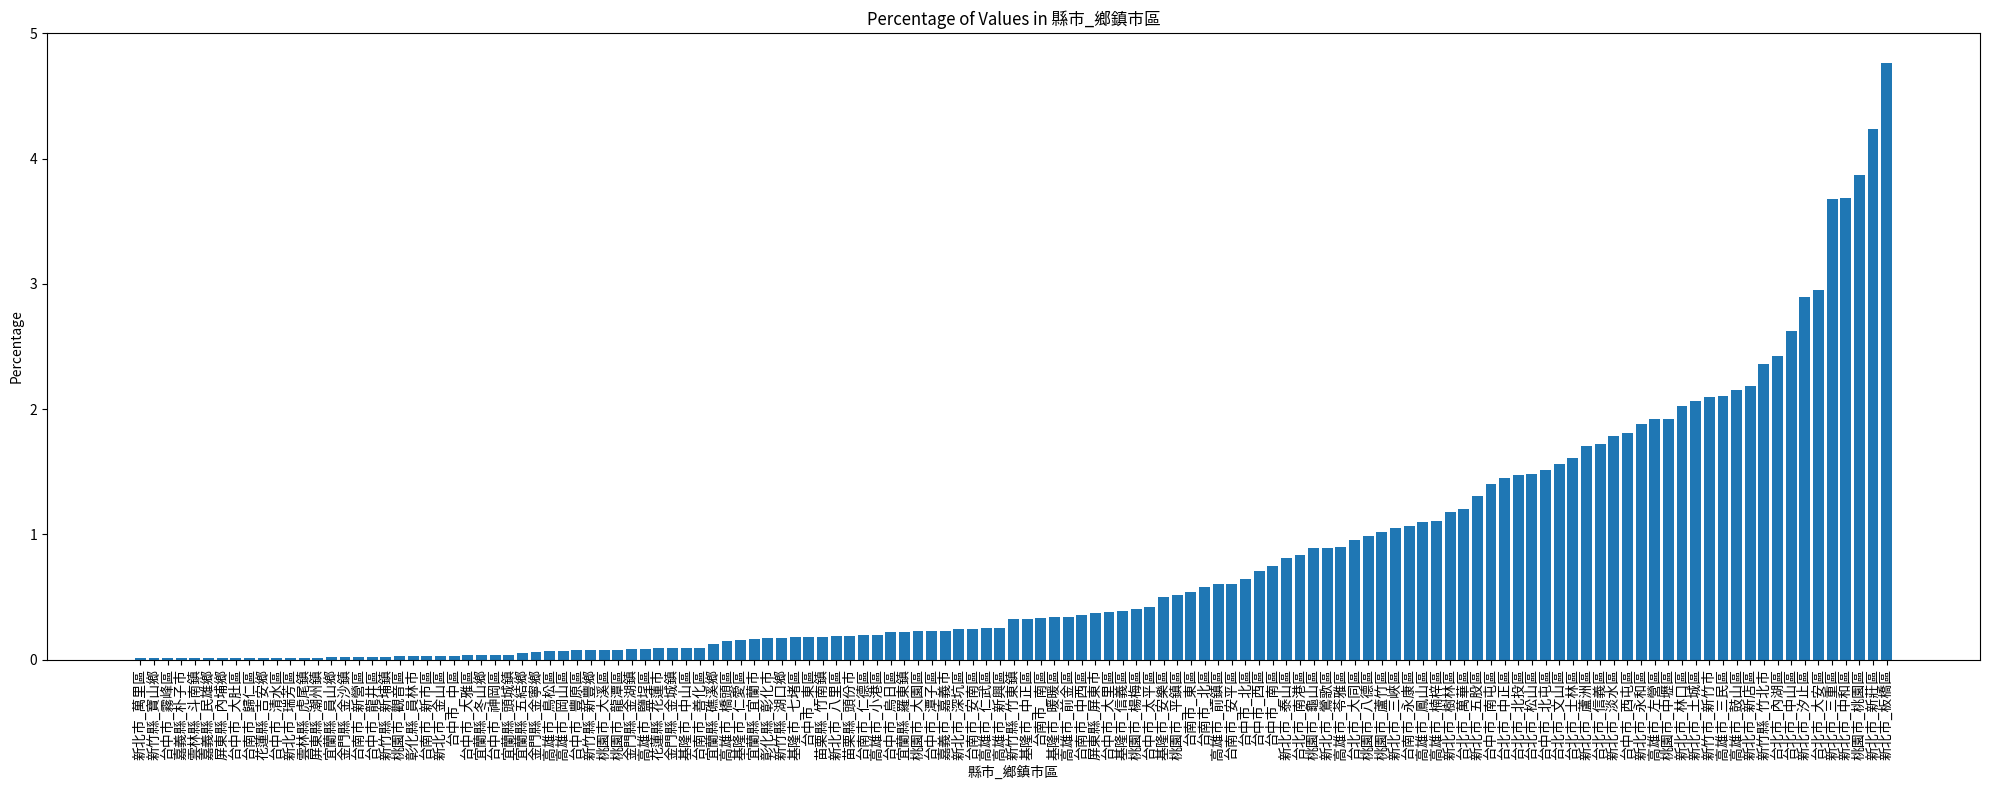

In [632]:
column_name = '縣市_鄉鎮市區'

# Calculate the value counts and percentages
value_counts = train[column_name].value_counts()
percentages = (value_counts / len(train)) * 100

# Create a DataFrame to display the results
value_percentage_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percentages.values})

# Sort the DataFrame by percentage in descending order
value_percentage_df = value_percentage_df.sort_values(by='Percentage', ascending=True)

plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.bar(value_percentage_df['Value'], value_percentage_df['Percentage'])
plt.xlabel(column_name)
plt.ylabel('Percentage')
plt.title(f'Percentage of Values in {column_name}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure boundaries

# Show the plot
plt.show()

由於鄉鎮市區中不同的值太多且有一些值太稀少，我打算合併成group。先看一下不同區域"單價"的mean和median

In [633]:
def plot_mean_and_median(df, column_name, target_column='單價'):
    # Group by the specified column and calculate mean and median
    grouped_data = df.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

    # Sort the dataframes by mean and median values
    sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
    sorted_median_data = grouped_data.sort_values(by='median', ascending=False)

    # Create a plot for the sorted mean
    plt.figure(figsize=(20, 8))
    plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
    plt.xlabel(column_name)
    plt.ylabel(f'Mean {target_column}')
    plt.title(f'Sorted Mean {target_column} by {column_name}')
    plt.xticks(rotation=90)  # Adjust rotation as needed
    plt.tight_layout()
    plt.show()

    # Create a plot for the sorted median
    plt.figure(figsize=(20, 8))
    plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
    plt.xlabel(column_name)
    plt.ylabel(f'Median {target_column}')
    plt.title(f'Sorted Median {target_column} by {column_name}')
    plt.xticks(rotation=90)  # Adjust rotation as needed
    plt.tight_layout()
    plt.show()

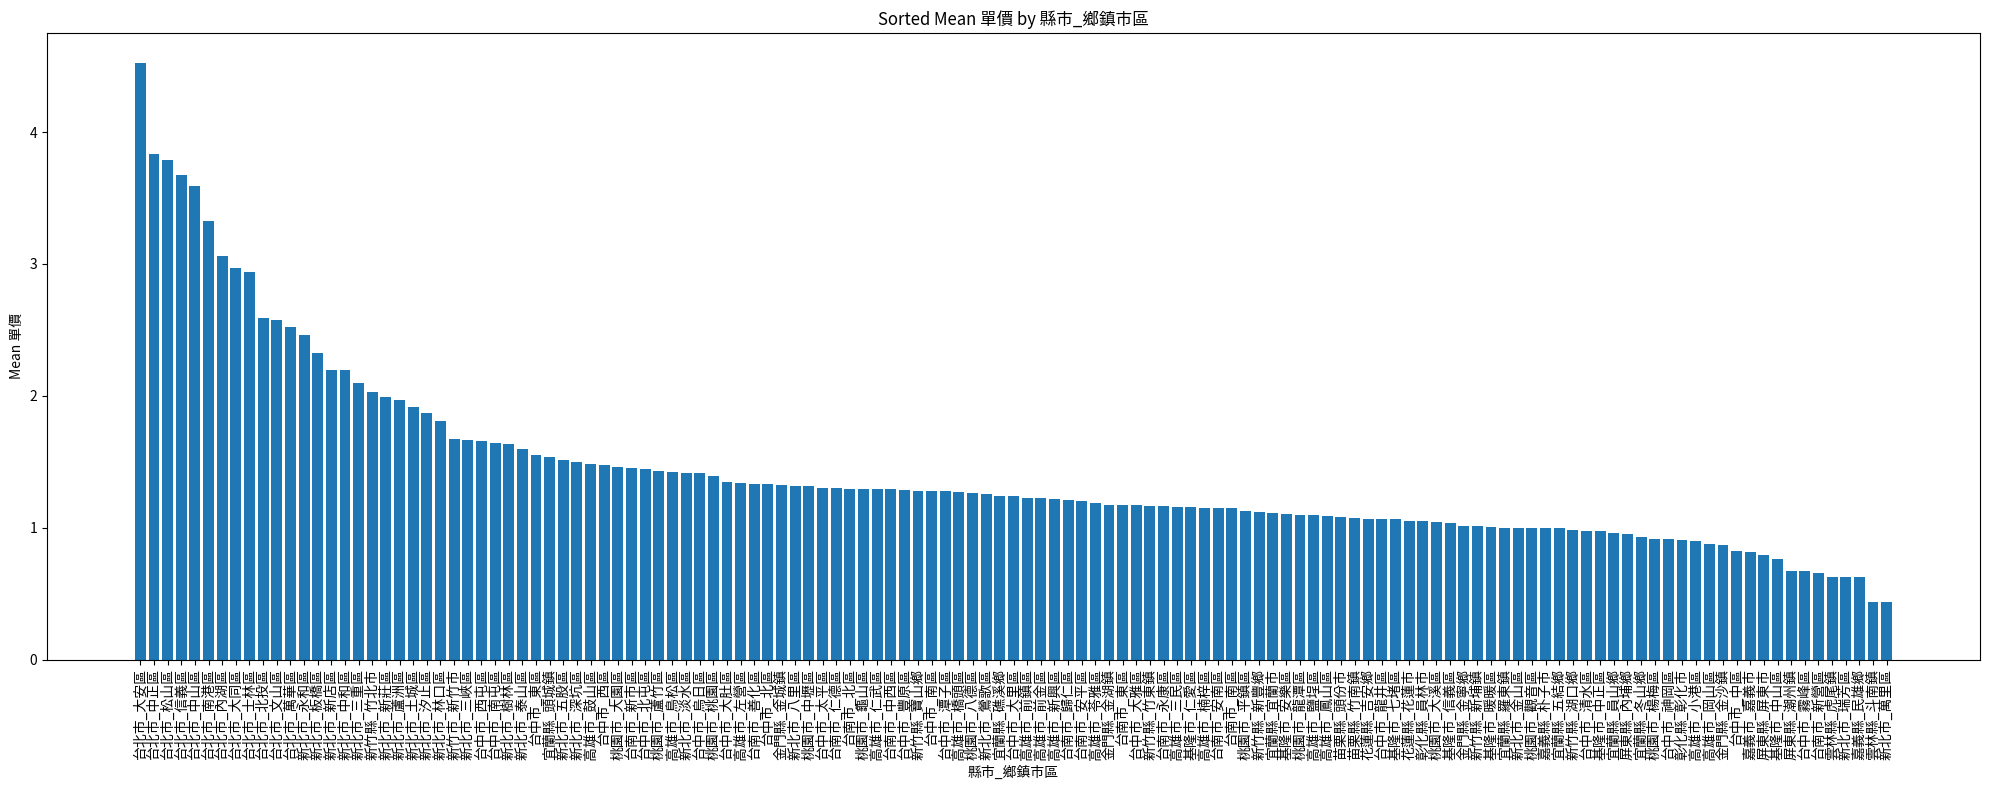

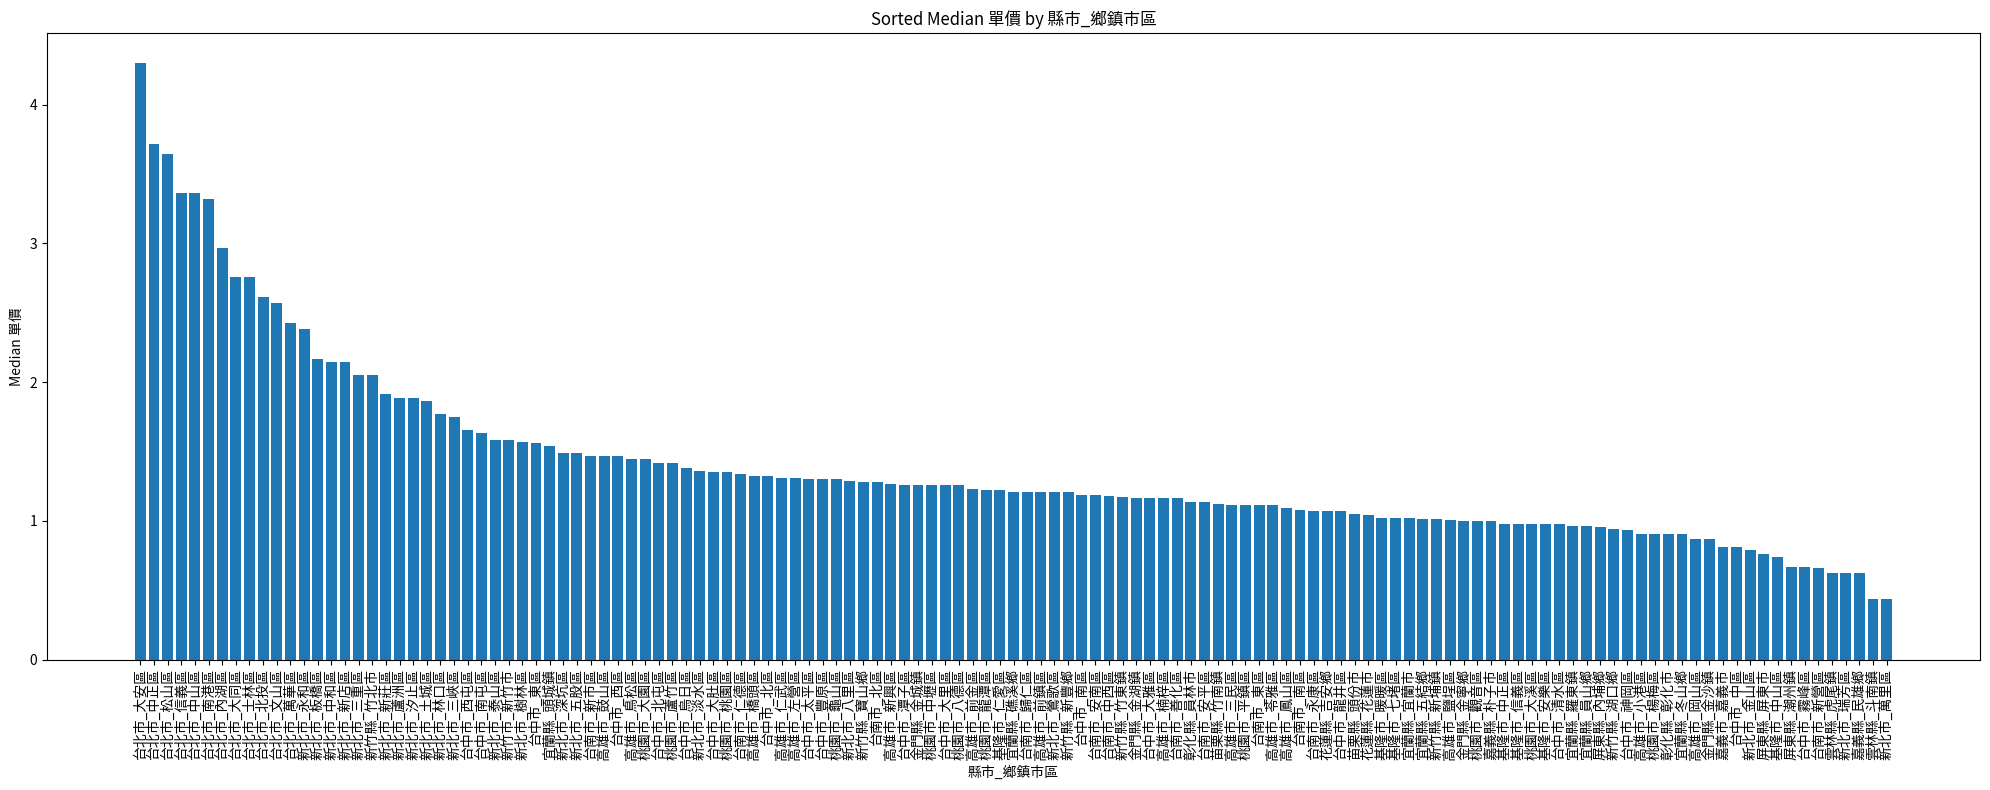

In [634]:
plot_mean_and_median(train, '縣市_鄉鎮市區')

mean跟median差異不大，且分布符合常理(貴的地方都在台北，便宜的都是鄉下)，因此我打算根據上表、我對房價的了解以及網路上找的各鄉鎮市區單價區間分組

**test data為2021-2022交易資料，為了避免data leakage，我們關注2021年以前之資料當作historical data**

In [635]:
df = df[(df['交易year'] < 2021) & (df['交易year'] >= 2018)]

In [636]:

# Group the DataFrame by '鄉鎮市區' and calculate the desired statistics
grouped_data = df.groupby('縣市_鄉鎮市區')[['單價元坪', '總價元']].agg(['mean', 'median', 'max', 'min'])

# Reset the index to make the '鄉鎮市區' column a regular column
grouped_data = grouped_data.reset_index()

# Rename the columns for clarity
grouped_data.columns = ['縣市_鄉鎮市區', '單價元坪_mean', '單價元坪_median', '單價元坪_max', '單價元坪_min', '總價元_mean', '總價元_median', '總價元_max', '總價元_min']

In [637]:
十 = ["台北市_大安區", "台北市_中正區", "台北市_信義區", "台北市_中山區", "台北市_松山區"]
九 = ["台北市_大同區", "台北市_士林區", "台北市_內湖區", "台北市_南港區", "台北市_萬華區", "台北市_文山區", "台北市_北投區"]
八 = ["新北市_永和區", "新北市_板橋區", "新北市_中和區", "新北市_新店區", "新北市_三重區", "新北市_新莊區", "新北市_蘆洲區", "新北市_土城區", "新北市_汐止區", "新北市_坪林區", "新竹縣_竹北市", "新北市_平溪區", "新北市_汐止區"]
七 = ["新北市_泰山區", "新北市_林口區", "新北市_五股區", "新北市_樹林區", "新北市_深坑區", "新北市_三峽區", "苗栗縣_泰安鄉", "台中市_和平區", "台中市_南屯區", "南投縣_仁愛鄉", "台中市_西屯區"]
六 = ["高雄市_前金區", "高雄市_鼓山區", "桃園市_桃園區", "新北市_淡水區", "桃園市_龜山區", "宜蘭縣_頭城鎮", "台中市_北屯區", "新竹市_新竹市", "台中市_烏日區", "台中市_西區", "新北市_鶯歌區", "桃園市_蘆竹區", "高雄市_仁武區", "高雄市_苓雅區", "新北市_八里區", "台中市_神岡區", "高雄市_左營區", "台中市_東區", "桃園市_大園區", "台中市_豐原區", "金門縣_金城鎮", "台中市_大雅區", "台中市_北區", "台中市_后里區", "新竹縣_新埔鎮", "台中市_南區", "台中市_太平區", "桃園市_中壢區", "宜蘭縣_礁溪鄉", "台中市_沙鹿區", "台中市_大里區", "金門縣_金湖鎮", "台中市_潭子區"]
五 = grouped_data.query("單價元坪_median <= 200000 & 單價元坪_median > 175000")["縣市_鄉鎮市區"].tolist()
四 = grouped_data.query("單價元坪_median <= 175000 & 單價元坪_median > 150000")["縣市_鄉鎮市區"].tolist()
三 = grouped_data.query("單價元坪_median <= 150000 & 單價元坪_median > 100000")["縣市_鄉鎮市區"].tolist()
二 = grouped_data.query("單價元坪_median <= 100000 & 單價元坪_median > 50000")["縣市_鄉鎮市區"].tolist()
一 = grouped_data.query("單價元坪_median <= 50000")["縣市_鄉鎮市區"].tolist()

In [638]:
for index, row in train.iterrows():
    if row["縣市_鄉鎮市區"] in 十:
        train.at[index, "縣市_鄉鎮市區"] = "10"
    elif row["縣市_鄉鎮市區"] in 九:
        train.at[index, "縣市_鄉鎮市區"] = "9"
    elif row["縣市_鄉鎮市區"] in 八:
        train.at[index, "縣市_鄉鎮市區"] = "8"
    elif row["縣市_鄉鎮市區"] in 七:
        train.at[index, "縣市_鄉鎮市區"] = "7"
    elif row["縣市_鄉鎮市區"] in 六:
        train.at[index, "縣市_鄉鎮市區"] = "6"
    elif row["縣市_鄉鎮市區"] in 五:
        train.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train.at[index, "縣市_鄉鎮市區"] = "1"

**此feature應該做ordinal encoding**

* 主要用途

In [639]:
#plot_mean_and_median(train, '主要用途')

**此feature可能要做1hot encoding**

* 主要建材

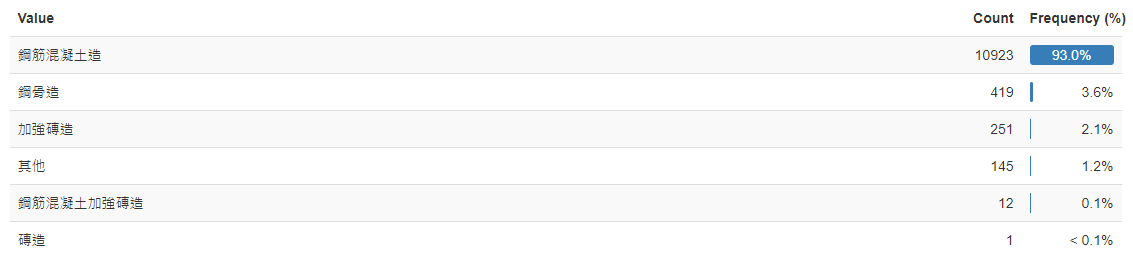

In [640]:
#plot_mean_and_median(train, "主要建材")

In [641]:
material_mapping = {
    "鋼骨造": "鋼骨造",
    "其他": "其他",
    "加強磚造": "其他",
    "磚造": "其他",
    "鋼筋混凝土造": "其他",
    "鋼筋混凝土加強磚造": "鋼筋混凝土加強磚造"
}
train['主要建材_分組'] = train['主要建材'].map(material_mapping)

In [642]:
#plot_mean_and_median(train, "主要建材_分組")

**此feature可能做ordinal encoding**

## Feature Generation

### 地理位置衍生

* 先將橫坐標、縱坐標轉換Longitude、Latitude(將TWD97二度分帶座標值轉換為經緯度)

In [643]:
# function來源: https://tylerastro.medium.com/twd97-to-longitude-latitude-dde820d83405
def twd97_to_lonlat(x=174458.0,y=2525824.0):
    """
    Parameters
    ----------
    x : float
        TWD97 coord system. The default is 174458.0.
    y : float
        TWD97 coord system. The default is 2525824.0.
    Returns
    -------
    list
        [longitude, latitude]
    """
    
    a = 6378137
    b = 6356752.314245
    long_0 = 121 * math.pi / 180.0
    k0 = 0.9999
    dx = 250000
    dy = 0
    
    e = math.pow((1-math.pow(b, 2)/math.pow(a,2)), 0.5)
    
    x -= dx
    y -= dy
    
    M = y / k0
    
    mu = M / ( a*(1-math.pow(e, 2)/4 - 3*math.pow(e,4)/64 - 5 * math.pow(e, 6)/256))
    e1 = (1.0 - pow((1   - pow(e, 2)), 0.5)) / (1.0 +math.pow((1.0 -math.pow(e,2)), 0.5))
    
    j1 = 3*e1/2-27*math.pow(e1,3)/32
    j2 = 21 * math.pow(e1,2)/16 - 55 * math.pow(e1, 4)/32
    j3 = 151 * math.pow(e1, 3)/96
    j4 = 1097 * math.pow(e1, 4)/512
    
    fp = mu + j1 * math.sin(2*mu) + j2 * math.sin(4* mu) + j3 * math.sin(6*mu) + j4 * math.sin(8* mu)
    
    e2 = math.pow((e*a/b),2)
    c1 = math.pow(e2*math.cos(fp),2)
    t1 = math.pow(math.tan(fp),2)
    r1 = a * (1-math.pow(e,2)) / math.pow( (1-math.pow(e,2)* math.pow(math.sin(fp),2)), (3/2))
    n1 = a / math.pow((1-math.pow(e,2)*math.pow(math.sin(fp),2)),0.5)
    d = x / (n1*k0)
    
    q1 = n1* math.tan(fp) / r1
    q2 = math.pow(d,2)/2
    q3 = ( 5 + 3 * t1 + 10 * c1 - 4 * math.pow(c1,2) - 9 * e2 ) * math.pow(d,4)/24
    q4 = (61 + 90 * t1 + 298 * c1 + 45 * math.pow(t1,2) - 3 * math.pow(c1,2) - 252 * e2) * math.pow(d,6)/720
    lat = fp - q1 * (q2 - q3 + q4)
    
    
    q5 = d
    q6 = (1+2*t1+c1) * math.pow(d,3) / 6
    q7 = (5 - 2 * c1 + 28 * t1 - 3 * math.pow(c1,2) + 8 * e2 + 24 * math.pow(t1,2)) * math.pow(d,5) / 120
    lon = long_0 + (q5 - q6 + q7) / math.cos(fp)
    
    lat = (lat*180) / math.pi
    lon = (lon*180) / math.pi
    return [lon, lat]

In [644]:
train['long'], train['lat'] = zip(*train.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))

In [645]:
#train.head(3)

In [646]:
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

In [647]:

lats = list((train)['lat'].values)
longs = list((train)['long'].values)
locations = list(zip(lats, longs))


map1 = folium.Map(location=[24, 121.5], zoom_start=8.0)


FastMarkerCluster(data=locations).add_to(map1)

#map1

**training set沒有台東、南投、澎湖、苗栗、雲林的資料**

* 北中南東外島

In [648]:
city_to_region = {
    '北部': ['台北市', '新北市', '基隆市', '新竹市', '桃園市', '新竹縣'],
    '中部': ['台中市', '苗栗縣', '彰化縣', '南投縣', '雲林縣'],
    '南部': ['高雄市', '台南市', '嘉義市', '嘉義縣', '屏東縣', '澎湖縣'],
    '東部': ['花蓮縣', '臺東縣', '宜蘭縣'],
    '外島': ['澎湖縣', '金門縣', '連江縣']
}

# Create a function to map cities to regions
def map_city_to_region(city):
    for region, cities in city_to_region.items():
        if city in cities:
            return region
    return 'Unknown'  # Return 'Unknown' if city doesn't match any region

# Apply the mapping function to create the 'Region' column
train['region'] = train['縣市'].apply(map_city_to_region)



In [649]:
column_name = 'region'
target_column = '單價'

# Group by 'region' and calculate mean and median
grouped_data = train.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

# Sort the dataframes by mean and median values
sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
sorted_median_data = grouped_data.sort_values(by='median', ascending=False)


#plt.figure(figsize=(12, 6))
#plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
#plt.xlabel(column_name)
#plt.ylabel('Mean ' + target_column)
#plt.title(f'Sorted Mean {target_column} by {column_name}')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()


#plt.figure(figsize=(12, 6))
#plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
#plt.xlabel(column_name)
#plt.ylabel('Median ' + target_column)
#plt.title(f'Sorted Median {target_column} by {column_name}')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()

**此feature應該做ordinal encoding**

* 縣市層級(首都、直轄市...)

In [650]:

conditions = [
    train["縣市"] == "台北市",
    train["縣市"].isin(["新北市", "桃園市", "臺中市", "臺南市", "高雄市"])
]

values = ["capital", "municipality"]

# Use numpy.select to create the new "直轄市" column
train["直轄市"] = np.select(conditions, values, default="others")


column_name = '直轄市'
target_column = '單價'

grouped_data = train.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
sorted_median_data = grouped_data.sort_values(by='median', ascending=False)

#plt.figure(figsize=(12, 6))
#plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
#plt.xlabel(column_name)
#plt.ylabel('Mean ' + target_column)
#plt.title(f'Sorted Mean {target_column} by {column_name}')
#plt.xticks(rotation=0)  
#plt.tight_layout()
#plt.show()

#plt.figure(figsize=(12, 6))
#plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
#plt.xlabel(column_name)
#plt.ylabel('Median ' + target_column)
#plt.title(f'Sorted Median {target_column} by {column_name}')
#plt.xticks(rotation=0)  
#plt.tight_layout()
#plt.show()



**此feature應該做ordinal encoding**

* 里

import geopy
from geopy.geocoders import Nominatim
geopy.geocoders.options.default_user_agent = "my-application"
gnom=Nominatim(user_agent="http")
geopy.geocoders.options.default_user_agent = "my-application"
gnom=Nominatim(user_agent="http")
def reverse_geocode(row):
    try:
        location = gnom.reverse(f"{row['lat']}, {row['long']}", exactly_one=True)
        return location.address
    except:
        return "Address not found"  # Return a placeholder if address lookup fails

# Apply the reverse geocoding function to create the 'complete_location' column
train['complete_location'] = train.apply(reverse_geocode, axis=1)

* cluster_simil

在 fit()中使用 KMeans 聚類來識別訓練數據中的主要聚類，然後在transform()中使用 rbf_kernel() 來衡量每個樣本與每個聚類中心的相似程度。 創建一個 ClusterSimilarity 轉換器，將簇數設置為10。然後它使用訓練集中每個地區的緯度和經度調用 fit_transform()，並且可以按某個值加權。 transformer 使用 k-means 來定位集群，然後測量每個地區與所有 10 個集群中心之間的高斯 RBF 相似度。 結果是一個矩陣，每個區一行，每個集群一欄。

可以tune的參數: n_clusters、gamma、sample_weight

In [651]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = None, gamma = None, sample_weight = None, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.sample_weight = sample_weight
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=self.sample_weight)
        return self 
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

In [652]:
preprocessing_cluster_simil = ColumnTransformer(
    transformers=[
        ("geo", cluster_simil, ["lat", "long"])
    ],
      remainder= "passthrough"                        )  
preprocessing_cluster_simil

test_cluster_simil = train.copy()

test_cluster_simil = preprocessing_cluster_simil.fit_transform(test_cluster_simil)

#Put the new features back to the dataframe
train = pd.DataFrame(
    test_cluster_simil,
    columns=preprocessing_cluster_simil.get_feature_names_out(),
    index=train.index
)

train.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)
train.head(1)

,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 5 similarity,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,主要建材_分組,region,直轄市
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,0.999253,0.000821,0.214537,0.000027,0.707961,0.933729,0.003331,0.826641,0.984089,0.987646,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路,10,其他,北部,capital


## 房屋面積衍生

* 總面積(建物面積+車位面積 + 陽台面積) 及 物件面積占比

**確認陽台面積是否屬於附屬建物面積，先假設陽台面積屬於附屬建物面積**

建物面積 = 主建物面積 + 附屬建物面積

In [653]:
train["總面積"] = train["建物面積"] + train["車位面積"] + train["陽台面積"]
train["建物面積占比"] = train["建物面積"] / train["總面積"]
train["主建物面積占比"] = train["主建物面積"] / train["總面積"]
train["附屬建物面積占比"] = train["附屬建物面積"] / train["總面積"]
train["車位面積占比"] = train["車位面積"] / train["總面積"]
train["陽台面積占比總面積"] = train["陽台面積"] / train["總面積"]

* 該房屋面積佔訓練集內所屬鄉鎮市區房屋總面積之佔比

In [654]:
train['鄉鎮市區房屋總面積'] = train.groupby(['縣市_鄉鎮市區'])['總面積'].transform('sum')
train['該房屋總面積在訓練集內所屬鄉鎮市區房屋總面積之佔比'] = train["總面積"] / train['鄉鎮市區房屋總面積']

train["鄉鎮市區車位總面積"] = train.groupby(["縣市_鄉鎮市區"])['車位面積'].transform('sum')
train['該房屋車位面積在訓練集內所屬鄉鎮市區車位總面積之佔比'] = train['車位面積'] / train["鄉鎮市區車位總面積"]

train["鄉鎮市區車位總個數"] = train.groupby(["縣市_鄉鎮市區"])["車位個數"].transform('sum')
train["車位個數佔比鄉鎮市區總車位數量"] = train.apply(lambda row: 0 if row["鄉鎮市區車位總個數"] == 0 else row["車位個數"] / row["鄉鎮市區車位總個數"], axis=1)

* 坪數

**假設資料中的面積去識別化前皆為平方公尺**

In [655]:
train["房屋坪數"] = train["總面積"] * 0.3025
train["土地坪數"] = train["土地面積"] * 0.3025

* 土地面積

In [656]:
train["土地面積與建物面積之差"] = train["土地面積"] - train["建物面積"]
train["建物面積佔比土地面積"] = train["建物面積"] / train["土地面積"]

* 鄉鎮市區衍生 mean、 median...土地面積、總面積...、

In [657]:
grouped = train.groupby("縣市_鄉鎮市區").agg({
    "土地面積": ["mean", "median"],
    "總面積": ["mean", "median"],
    "車位面積": ["mean", "median"],
    "建物面積": ["mean", "median"]
})

# Renaming the columns to include the aggregation type
grouped.columns = [f"{col}_{agg}" for col, agg in grouped.columns]

train = train.merge(grouped, left_on="縣市_鄉鎮市區", right_index=True)

## 樓層衍生

* 移轉層次與總樓層數

In [658]:
train["樓層比例"] = train["移轉層次"] / train["總樓層數"]
train["樓層比例_mean"] = train.groupby("縣市_鄉鎮市區")['樓層比例'].transform('mean')
train["樓層比例_median"] = train.groupby("縣市_鄉鎮市區")['樓層比例'].transform('median')

train["鄉鎮市區樓層總數"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('sum')
train['樓層總數佔比鄉鎮市區樓層總數'] = train["總樓層數"] / train["鄉鎮市區樓層總數"]

train["鄉鎮市區總樓層數_mean"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('mean')
train["鄉鎮市區總樓層數_median"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('median')

train["移轉曾次佔比鄉鎮市區平均總樓層數"] = train["移轉層次"] / train["鄉鎮市區總樓層數_mean"]
train["移轉曾次佔比鄉鎮市區中位數總樓層數"] = train["移轉層次"] / train["鄉鎮市區總樓層數_median"]

train['頂樓'] = (train['移轉層次'] == train['總樓層數']) & (train['移轉層次'] > 1)
train['頂樓'] = train['頂樓'].astype(int)


There are no house that is at the first floor or basement. There is also no single building that only have one floor. 

In [659]:
#train.query("總樓層數 == 1 | 移轉層次 == 1 | 移轉層次 < 1")

## 建物型態衍生

* 建物型態、電梯

In [660]:
train['建物型態2'] = train['建物型態'].str.split('(').str[0]
train['電梯'] = train['建物型態'].str.contains('有電梯').astype(int)


In [661]:
#plot_mean_and_median(train, '建物型態2')

**使用1hot encoding**

or

**使用ordinal encoding，透天厝為0，其他為1**

## 備註衍生

* 備註(花台、露台等)

In [662]:
train["備註"].unique()

array([nan, '屋突39.44平方公尺(參閱建物測量成果圖)', '其他面積:屋頂突出物', '露臺12.72平方公尺',
       '花台0.5平方公尺', '露臺4.4', '花台1.4平方公尺', '露台:7.92', '露台:15.87平方公尺 ',
       '機電4.13', '花台2.56㎡', '露台103.92㎡、花台1.76㎡', '主要建材：鋼骨鋼筋混凝土造',
       '附屬建物含露臺93.08平方公尺', '夾層38.87', '二層66.42、陽台8.76平方公尺', '露台:12.9平方公尺',
       '露台31.82平方公尺', '夾層25.93平方公尺', '露台16.87平方公尺', '主建物內含夾層面積25.24平方公尺',
       '主要建材：鋼筋混凝土造、鋼骨鋼筋混凝土造', '陽台10.08、花台0.61、露樑0.13', '露台11.36',
       '陽台7.77露台86.58花台17.64樓梯間5.99', '九層59.63㎡、九層夾層10.54㎡', '花台2.65㎡',
       '露台38.06㎡ ', '門牌登載為8樓實際為7樓 ', '花台1.21㎡', '花台0.93㎡ ',
       '陽台面積：9.36m2、花台面積：0.81m2、雨遮面積：0.70m2', '花台0.79㎡',
       '三層82.74㎡、陽台11.74㎡', '十一層74.36㎡、第十一層夾層23.79㎡', '花台0.84㎡',
       '花台4.18㎡ ', '花台2.64㎡', '花台0.53㎡ ', 'A2-7F', '花台1.07㎡', '主要建材：鋼骨造 ',
       '花台2.94㎡ ', '花台0.71㎡', 'A1棟9樓', '花台4.82㎡', '五層90.11㎡、陽台5.80㎡',
       '其他面積為花台', '花台1.54㎡', '花台1.67㎡', '九層96.44㎡、第九層夾層31.98㎡', '花台2.12㎡',
       '露台56.77M2、花台2M2', '花台2.91㎡', '花台1.38㎡', '花台0.46㎡',
       '花台1.18㎡、樑柱0.77㎡', '花台1.16㎡', '花台0.55㎡', 

In [663]:
train['備註'] = train['備註'].fillna('')
train['花台'] = train['備註'].str.contains('花台').astype(int)
train['露臺'] = train['備註'].str.contains('露臺').astype(int)
train['夾層'] = train['備註'].str.contains('夾層').astype(int)
train['雨遮'] = train['備註'].str.contains('雨遮').astype(int)

train['是否有其他物件'] = (train['備註'].str.contains('花台') & train['備註'].str.contains('露臺') & train['備註'].str.contains('夾層') & train['備註'].str.contains('雨遮') & train['備註'].str.contains('暸望室')).astype(int)

**處理備註的方式有待討論**

----

## Web Scraping Data 衍生

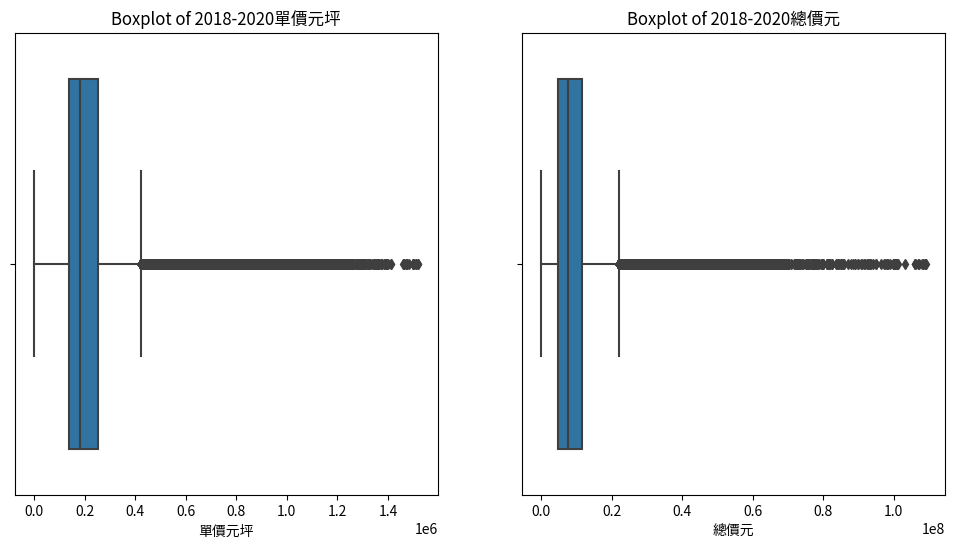

In [664]:

#filtered_df_2018_2020 = df[(df['交易year'] < 2021) & (df['交易year'] >= 2018)]

def remove_outliers(group):
    Q1_price = group['單價元坪'].quantile(0.25)
    Q3_price = group['單價元坪'].quantile(0.75)
    IQR_price = Q3_price - Q1_price
    lower_bound_price = Q1_price - 1.5 * IQR_price
    upper_bound_price = Q3_price + 1.5 * IQR_price
    
    Q1_total_price = group['總價元'].quantile(0.25)
    Q3_total_price = group['總價元'].quantile(0.75)
    IQR_total_price = Q3_total_price - Q1_total_price
    lower_bound_total_price = Q1_total_price - 1.5 * IQR_total_price
    upper_bound_total_price = Q3_total_price + 1.5 * IQR_total_price
    
    return group[
        (group['單價元坪'] >= lower_bound_price) & (group['單價元坪'] <= upper_bound_price) &
        (group['總價元'] >= lower_bound_total_price) & (group['總價元'] <= upper_bound_total_price)
    ]

filtered_df_2018_2020 = df

df_no_outliers_2018_2020  = filtered_df_2018_2020.groupby('縣市_鄉鎮市區').apply(remove_outliers).reset_index(drop=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create boxplots for "單價元坪" and "總價元"
sns.boxplot(x=df_no_outliers_2018_2020['單價元坪'], ax=axes[0])
sns.boxplot(x=df_no_outliers_2018_2020['總價元'], ax=axes[1])

axes[0].set_title('Boxplot of 2018-2020單價元坪')
axes[1].set_title('Boxplot of 2018-2020總價元')


plt.show()

# Group the DataFrame by '鄉鎮市區' and calculate the desired statistics
grouped_data_2018_2020 = df_no_outliers_2018_2020.groupby('縣市_鄉鎮市區')[['單價元坪', '總價元']].agg(['mean', 'median', 'max', 'min'])


grouped_data_2018_2020 = grouped_data_2018_2020.reset_index()

grouped_data_2018_2020.columns = ['縣市_鄉鎮市區', 'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020', 'web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020', 'web總價元_mean_2018_2020', 'web總價元_median_2018_2020', 'web總價元_max_2018_2020', 'web總價元_min_2018_2020']
grouped_data_2018_2020.head(1)

train = pd.merge(train, grouped_data_2018_2020, on='縣市_鄉鎮市區', how='left')

In [666]:
grouped_data_2018_2020.to_csv("historical_2018_2020_鄉鎮市區.csv", index = False)

---

## Feature Generation Pipeline

In [492]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = None, gamma = None, sample_weight = None, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.sample_weight = sample_weight
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=self.sample_weight)
        return self 
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [493]:
#conbining the columns
class CombineColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, source_columns, target_column, separator='_'):
        self.source_columns = source_columns
        self.target_column = target_column
        self.separator = separator
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()  
        X_copy[self.target_column] = X_copy[self.source_columns].apply(lambda row: self.separator.join(row), axis=1)
        return X_copy

In [494]:
#This is the encoding Transofrmer 
class MapValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, sets_mapping):
        self.column = column
        self.sets_mapping = sets_mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()  
        X_copy[self.column] = X_copy[self.column].apply(self._map_value)
        return X_copy
    
    def _map_value(self, value):
        for set_name, set_values in self.sets_mapping.items():
            if value in set_values:
                return set_name
        return "其他"  # If no match is found, return the original value

In [495]:
class MapValuesTransformer2(BaseEstimator, TransformerMixin):
    def __init__(self, column, mapping):
        self.column = column
        self.mapping = mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].map(self.mapping).fillna(0)
        return X_copy

In [496]:
#lat and long
class CoordinateConverter(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['long'], X_transformed['lat'] = zip(*X_transformed.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))
        return X_transformed



In [497]:
#region
class create_region(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['region'] = X_transformed.apply(lambda row: map_city_to_region(row['縣市']), axis=1)
        return X_transformed
    


In [498]:
#總面積
class CalculateTotalArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["總面積"] = X_copy["建物面積"] + X_copy["車位面積"] + X_copy["陽台面積"]
        return X_copy

#建屋面積占比
class CalculateAreaRatios(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["建物面積占比"] = X_copy["建物面積"] / X_copy["總面積"]
        X_copy["主建物面積占比"] = X_copy["主建物面積"] / X_copy["總面積"]
        X_copy["附屬建物面積占比"] = X_copy["附屬建物面積"] / X_copy["總面積"]
        X_copy["車位面積占比"] = X_copy["車位面積"] / X_copy["總面積"]
        X_copy["陽台面積占比總面積"] = X_copy["陽台面積"] / X_copy["總面積"]
        return X_copy
    



In [499]:
#鄉鎮市區總數及房屋佔比:總面積、車位面積、車位個數
class CalculateCountyArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['鄉鎮市區房屋總面積'] = X_copy.groupby(['縣市_鄉鎮市區'])['總面積'].transform('sum')
        X_copy["鄉鎮市區車位總面積"] = X_copy.groupby(["縣市_鄉鎮市區"])['車位面積'].transform('sum')
        X_copy["鄉鎮市區車位總個數"] = X_copy.groupby(["縣市_鄉鎮市區"])["車位個數"].transform('sum')
        return X_copy

class CalculateCountyAreaRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['該房屋總面積在訓練集內所屬鄉鎮市區房屋總面積之佔比'] = X_copy["總面積"] / X_copy['鄉鎮市區房屋總面積']
        X_copy['該房屋車位面積在訓練集內所屬鄉鎮市區車位總面積之佔比'] = X_copy['車位面積'] / X_copy["鄉鎮市區車位總面積"]
        X_copy["車位個數佔比鄉鎮市區總車位數量"] = X_copy.apply(lambda row: 0 if row["鄉鎮市區車位總個數"] == 0 else row["車位個數"] / row["鄉鎮市區車位總個數"], axis=1) 
        return X_copy  




In [500]:
#坪數
class CalculateSquareFeet(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["房屋坪數"] = X_copy["總面積"] * 0.3025
        X_copy["土地坪數"] = X_copy["土地面積"] * 0.3025
        return X_copy




In [501]:
#土地面積
class CalculateLandArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["土地面積與建物面積之差"] = X_copy["土地面積"] - X_copy["建物面積"]
        X_copy["建物面積佔比土地面積"] = X_copy["建物面積"] / X_copy["土地面積"]
        return X_copy



In [502]:
#鄉鎮市區均值中位數
class CalculateMeanMedianCountyArea(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_column):
        self.groupby_column = groupby_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        grouped = X.groupby(self.groupby_column).agg({
            "土地面積": ["mean", "median"],
            "總面積": ["mean", "median"],
            "車位面積": ["mean", "median"],
            "建物面積": ["mean", "median"]
        })


        grouped.columns = [f"{col}_{agg}" for col, agg in grouped.columns]


        X_merged = X.merge(grouped, left_on=self.groupby_column, right_index=True)
        return X_merged



In [503]:
#直轄市
class CreateDirectControlCityColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        conditions = [
            X["縣市"] == "台北市",
            X["縣市"].isin(["新北市", "桃園市", "臺中市", "臺南市", "高雄市"])
        ]
        values = ["capital", "municipality"]
        X["直轄市"] = np.select(conditions, values, default="others")
        return X
    

    

In [504]:

#樓層
class CalculateFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["樓層比例"] = X_copy["移轉層次"] / X_copy["總樓層數"]
        return X_copy

class AggregateFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["樓層比例_mean"] = X_copy.groupby("縣市_鄉鎮市區")["樓層比例"].transform("mean")
        X_copy["樓層比例_median"] = X_copy.groupby("縣市_鄉鎮市區")["樓層比例"].transform("median")
        return X_copy

class CalculateTotalFloors(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區樓層總數"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("sum")
        return X_copy

class CalculateRelativeFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["移轉曾次佔比鄉鎮市區平均總樓層數"] = X_copy["移轉層次"] / X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("mean")
        X_copy["移轉曾次佔比鄉鎮市區中位數總樓層數"] = X_copy["移轉層次"] / X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("median")
        return X_copy

class IdentifyTopFloor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['頂樓'] = ((X_copy['移轉層次'] == X_copy['總樓層數']) & (X_copy['移轉層次'] > 1)).astype(int)
        return X_copy

class CalculateTotalFloorMean(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區總樓層數_mean"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("mean")
        return X_copy

class CalculateTotalFloorMedian(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區總樓層數_median"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("median")
        return X_copy
    
#建物型態、電梯
class ExtractBuildingType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['建物型態2'] = X_copy['建物型態'].str.split('(').str[0]
        return X_copy

class ExtractElevatorPresence(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['電梯'] = X_copy['建物型態'].str.contains('有電梯').astype(int)
        return X_copy

class ExtractAdditionalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['備註'] = X_copy['備註'].fillna('')
        X_copy['花台'] = X_copy['備註'].str.contains('花台').astype(int)
        X_copy['露臺'] = X_copy['備註'].str.contains('露臺').astype(int)
        X_copy['夾層'] = X_copy['備註'].str.contains('夾層').astype(int)
        X_copy['雨遮'] = X_copy['備註'].str.contains('雨遮').astype(int)
        X_copy['是否有其他物件'] = (X_copy['備註'].str.contains('花台') &
                                   X_copy['備註'].str.contains('露臺') &
                                   X_copy['備註'].str.contains('夾層') &
                                   X_copy['備註'].str.contains('雨遮') &
                                   X_copy['備註'].str.contains('暸望室')).astype(int)
        X_copy["備註"].replace('', np.nan, inplace=True)
        return X_copy





In [505]:
#應用Class

class MergeData(BaseEstimator, TransformerMixin):
    def __init__(self, data_to_merge, on_column, how):
        self.data_to_merge = data_to_merge
        self.on_column = on_column
        self.how = how
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_merged = X.merge(self.data_to_merge, on=self.on_column, how=self.how)
        return X_merged

class FillMissingByCategory(BaseEstimator, TransformerMixin):
    def __init__(self, column_to_fill, grouping_column, method='mean'):
        self.column_to_fill = column_to_fill
        self.grouping_column = grouping_column
        self.method = method
    
    def fit(self, X, y=None):
        if self.method == 'mean':
            self.aggregation = X.groupby(self.grouping_column)[self.column_to_fill].mean()
        elif self.method == 'median':
            self.aggregation = X.groupby(self.grouping_column)[self.column_to_fill].median()
        else:
            raise ValueError("Invalid method. Please use 'mean' or 'median'.")
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_to_fill].fillna(X_copy[self.grouping_column].map(self.aggregation), inplace=True)
        return X_copy
    
    def get_feature_names_out(self, names=None):
        return self.column_to_fill


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy.drop(columns=self.columns_to_drop, inplace=True)
        return X_copy


In [506]:
# This is the mapping of encoding based on the source of web scraping, domain knowledge, and the training set itself.
encoding_縣市_鄉鎮市區 = {
    10 : 十,
    9 : 九,
    8 : 八,
    7 : 七,
    6 : 六,
    5 : 五,
    4 : 四,
    3 : 三,
    2 : 二,
    1 : 一
}

#This is the mapping for 主要建材
material_mapping = {
    "鋼骨造": "鋼骨造",
    "其他": "其他",
    "加強磚造": "其他",
    "磚造": "其他",
    "鋼筋混凝土造": "其他",
    "鋼筋混凝土加強磚造": "鋼筋混凝土加強磚造"
}

#主要用途_mapping
主要用途_mapping = {
    '一般事務所': 3,
    '商業用': 3,
    '工業用': 3,
    '辦公室': 2,
    '店鋪': 2,
    '住家用': 2,
    '集合住宅': 2,
    '其他': 2,
    '住工用': 2,
    '住商用': 2,
    '國民住宅': 2,
    '廠房': 1
}


In [507]:
feature_generation = Pipeline([
    #('create_縣市_鄉鎮市區_路名', CombineColumnsTransformer(['縣市', '鄉鎮市區', '路名'], '縣市_鄉鎮市區_路名')),
    ('create_縣市_鄉鎮市區', CombineColumnsTransformer(['縣市', '鄉鎮市區'], '縣市_鄉鎮市區')),
    ('merge_with_web_scraping_data', MergeData(data_to_merge=grouped_data_2018_2020,on_column="縣市_鄉鎮市區",how="left")),
    ('encoding_縣市_鄉鎮市區', MapValuesTransformer('縣市_鄉鎮市區', encoding_縣市_鄉鎮市區)),
    ('grouping_主要建材', MapValuesTransformer('主要建材', material_mapping)),
    #('主要用途_mapping', MapValuesTransformer2('主要用途', 主要用途_mapping)),
    ('coordinate_converter', CoordinateConverter()),
    ('create_region', create_region()),
    ('calculate_總面積', CalculateTotalArea()),
    #('calculate_面積占比', CalculateAreaRatios()),
    #('calculate_鄉鎮市區加總', CalculateCountyArea()),
    #('calculate_房屋佔比鄉鎮市區',CalculateCountyAreaRatio()),
    #('calculate_坪數', CalculateSquareFeet()),
    #('calculate_土地面積', CalculateLandArea()),
    #('calculate_鄉鎮市區均值中位數', CalculateMeanMedianCountyArea(groupby_column = '縣市_鄉鎮市區')),
    ('create_直轄市', CreateDirectControlCityColumn()),
    #('calculate_floor_ratio', CalculateFloorRatio()),
    #('aggregate_floor_ratio', AggregateFloorRatio()),
    #('calculate_total_floors', CalculateTotalFloors()),
    #('calculate_relative_floor_ratio', CalculateRelativeFloorRatio()),
    ('identify_top_floor', IdentifyTopFloor()),
    #('calculate_total_floor_mean', CalculateTotalFloorMean()),
    #('calculate_total_floor_median', CalculateTotalFloorMedian()),
    ('extract_building_type', ExtractBuildingType()),
    ('extract_elevator_presence', ExtractElevatorPresence()),
    #('extract_additional_features', ExtractAdditionalFeatures()),
])

Use X_train_copy for the experiments

In [508]:
X_train = train_raw.drop(columns=['單價'])
y_train = train_raw['單價'].copy()
X_train_copy = X_train.copy()
X_train_copy.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level
0,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路


In [509]:
#Just Testing if needed
#X_train_copy_sample = X_train_copy.head(50)
#X_train_copy_sample  = feature_generation.fit_transform(X_train_copy_sample )
#X_train_copy_sample.head(1)

In [510]:

X_train_copy  = feature_generation.fit_transform(X_train_copy)
X_train_copy.set_index(train_id_column, inplace=True)
X_train_copy.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,其他,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路,10,873438.842518,843247.52478,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,北部,-0.809779,capital,1,住宅大樓,1


In [511]:
test_copy = test.copy()
test_copy = feature_generation.fit_transform(test_copy)
test_copy.set_index(test_id_column, inplace=True)
#test_copy.head(1)

In [512]:
#X_train_copy.to_csv("X_train_copy.csv", index = False)

In [513]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11750 entries, TR-1 to TR-11751
Data columns (total 70 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        11750 non-null  object 
 1   縣市                        11750 non-null  object 
 2   鄉鎮市區                      11750 non-null  object 
 3   路名                        11750 non-null  object 
 4   土地面積                      11750 non-null  float64
 5   使用分區                      11750 non-null  object 
 6   移轉層次                      11750 non-null  int64  
 7   總樓層數                      11750 non-null  int64  
 8   主要用途                      11750 non-null  object 
 9   主要建材                      11750 non-null  object 
 10  建物型態                      11750 non-null  object 
 11  屋齡                        11750 non-null  float64
 12  建物面積                      11750 non-null  float64
 13  車位面積                      11750 non-null  float64
 14  車位個數 

## Feature Selection

Drop unnecessary columns if

- identification columns

- missing % >60

- only one unique value

- features that can be replaced by other columns (code vs. description)

- reference columns to other tables that are out of scope

- High correlated features
 

In [514]:
#X_train_copy.describe().T

In [515]:
id_col = ['鄉鎮市區', 'ID', '路名']

print(len(id_col))

3


In [516]:
def missing_perc(base, perc):
    desc_df = base.describe(include='all')
    missing_col = desc_df.T['count'].to_frame()
    missing_col['missing_perc'] = (len(base)- missing_col['count'])/len(base)*100
    missing_df = missing_col[missing_col['missing_perc'] >=perc]
    return missing_df

# get columns that missing % is larger than 60
missing_col = missing_perc(X_train_copy, 99)#.index
print(len(missing_col.index))
missing_col.index
missing_perc(X_train_copy, 99)

1


,count,missing_perc
備註,92,99.217021


In [517]:
missing_col

,count,missing_perc
備註,92,99.217021


In [518]:
def unique_ct_1(df):
    uniq_ct_list = []
    for i in df.columns:
        uniq_ct = df[i].nunique()
        uniq_ct_list.append(uniq_ct)
    d = {'col':df.columns,'ct':uniq_ct_list}
    df = pd.DataFrame(d)
    return df[df['ct'] ==1].col.tolist()

one_uniq_col = unique_ct_1(X_train_copy)
one_uniq_col 

[]

In [519]:
#features that can be replaced by other columns (code vs. description) and reference columns to other tables that are out of scope

ref_or_dup_col = ["建物型態"]

drop_col = id_col + missing_col.index.tolist() + one_uniq_col + ref_or_dup_col 

In [520]:
drop_col

['鄉鎮市區', 'ID', '路名', '備註', '建物型態']

In [521]:
X_train_copy = X_train_copy.drop(columns=drop_col, axis = 1)

In [522]:
X_train_copy.head(1)

,縣市,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,-0.256716,None,11,11,住家用,其他,32.583333,-0.174154,-0.819326,0.0,305266,2768378,0.393926,0.1837,-0.438452,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路,10,873438.842518,843247.52478,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,北部,-0.809779,capital,1,住宅大樓,1


* define a function to select features that are not correlated to one another -- set threshold to 0.95

Drop features which are highly correlated with one another -- this means there are some linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost.

In [523]:

def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    print(df_corr.shape)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out
df_corr = X_train_copy.corr(method='pearson', min_periods=1)
df_corr.head()
uncorrelated_factors = trimm_correlated(X_train_copy, 0.95)
uncorrelated_factors.shape
uncorrelated_factors.columns.tolist()
X_train_copy_num = uncorrelated_factors

class TrimCorrelated(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        # Calculate correlation matrix
        df_corr = X.corr(method='pearson', min_periods=1)
        # Identify uncorrelated columns
        df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > self.threshold).any()
        self.uncorrelated_columns_ = df_not_correlated[df_not_correlated.index][df_not_correlated].index.tolist()
        return self
    
    def transform(self, X):
        X_copy = X[self.uncorrelated_columns_]
        return X_copy
    def get_feature_names_out(self, names=None):
        return self.uncorrelated_columns_

(56, 56)


In [524]:
num_feature = X_train_copy_num.columns.tolist()
num_feature

['土地面積',
 '移轉層次',
 '總樓層數',
 '屋齡',
 '建物面積',
 '車位面積',
 '車位個數',
 '橫坐標',
 '縱坐標',
 '主建物面積',
 '陽台面積',
 '附屬建物面積',
 '站點數',
 '高度壞地標數',
 '中度壞地標數',
 '輕度壞地標數',
 'bad_score',
 '公園圖書館',
 '金融機構數',
 '學生教職員總人數',
 '附近超商數',
 '附近全聯數',
 'R_TPE',
 'O_TPE',
 'BR',
 'BL',
 'A',
 'G',
 'Y',
 'V',
 'C',
 'R_Kao',
 'O_Kao',
 'ATM數',
 '郵局數',
 '學生教職員總人數_國中',
 '學生教職員總人數_高中',
 '車站級別',
 'positive_clinic_數',
 '縣市_鄉鎮市區',
 'web單價元坪_mean_2018_2020',
 'web單價元坪_min_2018_2020',
 'web總價元_min_2018_2020',
 '總面積',
 '頂樓',
 '電梯']

In [525]:
cat_feature = X_train_copy.select_dtypes(include='object').columns.tolist()
cat_feature

['縣市',
 '使用分區',
 '主要用途',
 '主要建材',
 '縣市_鄉鎮市區_路名',
 '路_level',
 'region',
 '直轄市',
 '建物型態2']

In [526]:
feature_selected1 = X_train_copy[num_feature + cat_feature]

These are the columns that high correlated with some other columns

In [527]:
X_train_columns = set(X_train_copy.columns)
feature_selected_columns = set(feature_selected1.columns)

# Find the columns that are in X_train_copy.columns but not in feature_selected1.columns
columns_not_in_feature_selected = X_train_columns - feature_selected_columns

# Convert the result back to a list if needed
columns_not_in_feature_selected_list = list(columns_not_in_feature_selected)

# Print the columns that are in X_train_copy.columns but not in feature_selected1.columns
print(columns_not_in_feature_selected_list)

['web總價元_median_2018_2020', '權重_高中', '權重_國中', '權重', 'web總價元_mean_2018_2020', 'web單價元坪_median_2018_2020', 'web單價元坪_max_2018_2020', 'long', 'lat', 'web總價元_max_2018_2020']


In [528]:
#Save the very first feature selection, just internal data and web scraping data
#feature_selected1.to_csv("feature_selected1.csv")

# Modeling

## Preprocessing Pipeline

In [529]:

#Category Features
cat = X_train_copy.select_dtypes(include='object')

num = X_train_copy.select_dtypes(np.number)

In [530]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11750 entries, TR-1 to TR-11751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   縣市          11750 non-null  object
 1   使用分區        11750 non-null  object
 2   主要用途        11750 non-null  object
 3   主要建材        11750 non-null  object
 4   縣市_鄉鎮市區_路名  11750 non-null  object
 5   路_level     11750 non-null  object
 6   region      11750 non-null  object
 7   直轄市         11750 non-null  object
 8   建物型態2       11750 non-null  object
dtypes: object(9)
memory usage: 918.0+ KB


In [531]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11750 entries, TR-1 to TR-11751
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   土地面積                      11750 non-null  float64
 1   移轉層次                      11750 non-null  int64  
 2   總樓層數                      11750 non-null  int64  
 3   屋齡                        11750 non-null  float64
 4   建物面積                      11750 non-null  float64
 5   車位面積                      11750 non-null  float64
 6   車位個數                      11750 non-null  float64
 7   橫坐標                       11750 non-null  int64  
 8   縱坐標                       11750 non-null  int64  
 9   主建物面積                     11750 non-null  float64
 10  陽台面積                      11750 non-null  float64
 11  附屬建物面積                    11750 non-null  float64
 12  站點數                       11239 non-null  float64
 13  高度壞地標數                    3491 non-null   float64
 14  中度壞地標

In [532]:
X_train_copy.columns

Index(['縣市', '土地面積', '使用分區', '移轉層次', '總樓層數', '主要用途', '主要建材', '屋齡', '建物面積',
       '車位面積', '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積', '附屬建物面積', '縣市_鄉鎮市區_路名',
       '站點數', '高度壞地標數', '中度壞地標數', '輕度壞地標數', 'bad_score', '公園圖書館', '金融機構數',
       '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'R_TPE', 'O_TPE', 'BR', 'BL', 'A',
       'G', 'Y', 'V', 'C', 'R_Kao', 'O_Kao', 'ATM數', '郵局數', '學生教職員總人數_國中',
       '權重_國中', '學生教職員總人數_高中', '權重_高中', '車站級別', 'positive_clinic_數', '路_level',
       '縣市_鄉鎮市區', 'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020',
       'web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020',
       'web總價元_mean_2018_2020', 'web總價元_median_2018_2020',
       'web總價元_max_2018_2020', 'web總價元_min_2018_2020', 'long', 'lat', 'region',
       '總面積', '直轄市', '頂樓', '建物型態2', '電梯'],
      dtype='object')

In [533]:

cat_cols = ['縣市', '使用分區', 
            '主要用途', 
            '主要建材', 'region', '直轄市', '建物型態2', '縣市_鄉鎮市區_路名', '路_level']
#num_cols = ['土地面積', '移轉層次', '總樓層數','屋齡','建物面積', '車位面積', '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積', '附屬建物面積', '站點數',
            #'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020','web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020','web總價元_mean_2018_2020', 
            #'web總價元_median_2018_2020','web總價元_max_2018_2020', 'web總價元_min_2018_2020', 'long', 'lat','總面積', '頂樓', '金融機構數', '學生教職員總人數', '權重', '縣市_鄉鎮市區',
            #'高度壞地標數', '中度壞地標數', '輕度壞地標數', 'bad_score', '公園圖書館', 'R_TPE', 'O_TPE', 'BR', 'BL', 'A', 'G', 'Y', 'V', 'C', 'R_Kao', 'O_Kao']

grouping_input_column = ['縣市_鄉鎮市區', '站點數', '金融機構數', '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'ATM數', '郵局數', '學生教職員總人數_國中', '權重_國中',
                         '學生教職員總人數_高中', '權重_高中', 'positive_clinic_數'
                         #'positive_medical_staff_count', '權重_醫療'
                         ]

#bad_facilities_column = ['高度壞地標數', 
                         #'中度壞地標數', 
                         #'輕度壞地標數', 
                         #'bad_score']
#good_facilities_column = ['公園圖書館']


to_fill_zero_column = ['高度壞地標數', '中度壞地標數', '輕度壞地標數', 'bad_score', '公園圖書館', 'R_TPE', 'O_TPE', 
                       'BR', 
                       'BL', 'A', 'G', 
                       'Y',
                       'V',
                       'C', 'R_Kao', 'O_Kao'
                        ]

### cat_transformer

In [534]:
主要建材_mapping = [['鋼筋混凝土加強磚造', '其他', '鋼骨造']]
直轄市_mapping = [['others', 'municipality','capital']]
region_mapping = [[ '東部','外島','南部', '中部','北部']]
路_level_mapping = [['其他', '街', '路', '大道',]]

In [535]:
cat_transformer= make_column_transformer(
    (OrdinalEncoder(categories=主要建材_mapping), ['主要建材']),
    (OrdinalEncoder(categories=直轄市_mapping ), ['直轄市']),
    (OrdinalEncoder(categories=region_mapping ), ['region']),
    (OrdinalEncoder(categories=路_level_mapping ), ['路_level']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市_鄉鎮市區_路名']),
    (OneHotEncoder(handle_unknown="ignore"), ['主要用途']),
    (OneHotEncoder(handle_unknown="ignore"), ['建物型態2'])
)



### Missing Value Imputer

In [536]:
#bus_station_imputer 
bus_station_imputer = FillMissingByCategory(column_to_fill="站點數", grouping_column="縣市_鄉鎮市區", method= 'median')

# finance_imputer
finance_imputer= FillMissingByCategory(column_to_fill="金融機構數", grouping_column="縣市_鄉鎮市區", method= 'median')

#elementry_imputer
elementry_imputer_學生教職員總人數 = FillMissingByCategory(column_to_fill="學生教職員總人數", grouping_column="縣市_鄉鎮市區", method= 'median')
elementry_imputer_權重 = FillMissingByCategory(column_to_fill="權重", grouping_column="縣市_鄉鎮市區", method= 'median')

#store_imputer
store_imputer_超商 = FillMissingByCategory(column_to_fill="附近超商數", grouping_column="縣市_鄉鎮市區", method= 'median')
store_imputer_全聯 = FillMissingByCategory(column_to_fill="附近全聯數", grouping_column="縣市_鄉鎮市區", method= 'median')

#atm_inputer
atm_Inputer = FillMissingByCategory(column_to_fill="ATM數", grouping_column="縣市_鄉鎮市區", method= 'median')
#postoffice_inputer
postoffice_inputer = FillMissingByCategory(column_to_fill="郵局數", grouping_column="縣市_鄉鎮市區", method= 'median')

#junior_imputer
junior_imputer_學生教職員總人數 = FillMissingByCategory(column_to_fill="學生教職員總人數_國中", grouping_column="縣市_鄉鎮市區", method= 'median')
junior_imputer_權重 = FillMissingByCategory(column_to_fill="權重_國中", grouping_column="縣市_鄉鎮市區", method= 'median')

#highschool_imputer 
highschool_imputer_學生教職員總人數 = FillMissingByCategory(column_to_fill="學生教職員總人數_高中", grouping_column="縣市_鄉鎮市區", method= 'median')
highschool_imputer_權重 = FillMissingByCategory(column_to_fill="權重_高中", grouping_column="縣市_鄉鎮市區", method= 'median')

#positive_clinic_imputer
#positive_clinic_imputer_staff_count = FillMissingByCategory(column_to_fill="positive_medical_staff_count", grouping_column="縣市_鄉鎮市區", method= 'median')
#positive_clinic_imputer_權重_醫療 = FillMissingByCategory(column_to_fill="權重_醫療", grouping_column="縣市_鄉鎮市區", method= 'median')
positive_clinic_數_inputer = FillMissingByCategory(column_to_fill="positive_clinic_數", grouping_column="縣市_鄉鎮市區", method= 'median')
#stationlevel_imputer
stationlevel_imputer = SimpleImputer(strategy = "constant" , fill_value = 6)

#fill_zero_imputer
fill_zero_imputer = SimpleImputer(strategy = "constant" , fill_value = 0)

In [537]:
grouping_imputer = Pipeline([ 
     ('bus_station_imputer', bus_station_imputer),
     ('finance_imputer', finance_imputer),
     ('elementry_imputer_學生教職員總人數', elementry_imputer_學生教職員總人數),
     ('elementry_imputer_權重', elementry_imputer_權重),
     ('store_imputer_超商', store_imputer_超商),
     ('store_imputer_全聯', store_imputer_全聯),
     ('atm_Inputer', atm_Inputer),
     ('postoffice_inputer', postoffice_inputer),
     ('junior_imputer_學生教職員總人數', junior_imputer_學生教職員總人數),
     ('junior_imputer_權重', junior_imputer_權重),
     ('highschool_imputer_學生教職員總人數', highschool_imputer_學生教職員總人數),
     ('highschool_imputer_權重', highschool_imputer_權重),
     #('positive_clinic_imputer_staff_count', positive_clinic_imputer_staff_count),
     #('positive_clinic_imputer_權重_醫療', positive_clinic_imputer_權重_醫療),
     ('positive_clinic_數_inputer', positive_clinic_數_inputer),
     ('trim_hogh_corr', TrimCorrelated(0.95)),
                            
    #('standardization', StandardScaler()),
    #('log_transform', log_transformer)
])

In [538]:
num_data_after_grouping_imputer = grouping_imputer.fit_transform(X_train_copy)

In [539]:
to_fill_zero_column

['高度壞地標數',
 '中度壞地標數',
 '輕度壞地標數',
 'bad_score',
 '公園圖書館',
 'R_TPE',
 'O_TPE',
 'BR',
 'BL',
 'A',
 'G',
 'Y',
 'V',
 'C',
 'R_Kao',
 'O_Kao']

In [540]:
left_missing_values = num_data_after_grouping_imputer.isna().sum()

# Filter columns with missing values
columns_with_missing_values = left_missing_values[left_missing_values > 0]

# Print the columns with missing values
print(columns_with_missing_values)

高度壞地標數       8259 
中度壞地標數       8259 
輕度壞地標數       8259 
bad_score    8259 
公園圖書館        5654 
R_TPE        8998 
O_TPE        8998 
BR           10394
BL           8998 
A            8936 
G            8998 
Y            10354
V            11617
C            11499
R_Kao        11476
O_Kao        11476
車站級別         5    
dtype: int64


In [541]:
drop_col

['鄉鎮市區', 'ID', '路名', '備註', '建物型態']

### Preprocessing

In [542]:

preprocessing = ColumnTransformer(
    transformers=[
        ("categorical", cat_transformer, cat_cols),
        ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["lat", "long"]), #This is another feature generation
        ('stationlevel_imputer', stationlevel_imputer, ["車站級別"]),
        ('fill_zero_imputer', fill_zero_imputer, to_fill_zero_column), 
        ('grouping_imputer', grouping_imputer, grouping_input_column),
    ],
      remainder="passthrough")  
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 ColumnTransformer(transformers=[('ordinalencoder-1',
                                                                  OrdinalEncoder(categories=[['鋼筋混凝土加強磚造',
                                                                                              '其他',
                                                                                              '鋼骨造']]),
                                                                  ['主要建材']),
                                                                 ('ordinalencoder-2',
                                                                  OrdinalEncoder(categories=[['others',
                                                                                              'municipality',
                                                                                              'capital']]),
                                                                  ['直轄市']),
                                                                 ('ordinalencoder-3',
                                                                  OrdinalEncoder(categories=[['東部',
                                                                                              '外島',
                                                                                              '南部',
                                                                                              '中部',
                                                                                              '...
                                                                        grouping_column='縣市_鄉鎮市區',
                                                                        method='median')),
                                                 ('positive_clinic_數_inputer',
                                                  FillMissingByCategory(column_to_fill='positive_clinic_數',
                                                                        grouping_column='縣市_鄉鎮市區',
                                                                        method='median')),
                                                 ('trim_hogh_corr',
                                                  TrimCorrelated(threshold=0.95))]),
                                 ['縣市_鄉鎮市區', '站點數', '金融機構數', '學生教職員總人數', '權重',
                                  '附近超商數', '附近全聯數', 'ATM數', '郵局數',
                                  '學生教職員總人數_國中', '權重_國中', '學生教職員總人數_高中',
                                  '權重_高中', 'positive_clinic_數'])])

In [543]:
preprocessed = preprocessing.fit_transform(X_train_copy)
#preprocessed.shape

In [544]:
preprocessed.shape

(11750, 3851)

## Full Pipeline

In [545]:
drop_col

['鄉鎮市區', 'ID', '路名', '備註', '建物型態']

In [546]:
pipeline_test_rf = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("rf2", RandomForestRegressor(random_state=42)),
])

將目標變數轉為常態分佈

In [547]:

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal")

pipeline_test_rf = TransformedTargetRegressor(regressor=pipeline_test_rf, transformer=qt)

In [548]:
pipeline_test_rf.fit(X_train, y_train)


TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('create_縣市_鄉鎮市區',
                                                                       CombineColumnsTransformer(source_columns=['縣市',
                                                                                                                 '鄉鎮市區'],
                                                                                                 target_column='縣市_鄉鎮市區')),
                                                                      ('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_me...
                                                                                                        FillMissingByCategory(column_to_fill='positive_clinic_數',
                                                                                                                              grouping_column='縣市_鄉鎮市區',
                                                                                                                              method='median')),
                                                                                                       ('trim_hogh_corr',
                                                                                                        TrimCorrelated(threshold=0.95))]),
                                                                                       ['縣市_鄉鎮市區',
                                                                                        '站點數',
                                                                                        '金融機構數',
                                                                                        '學生教職員總人數',
                                                                                        '權重',
                                                                                        '附近超商數',
                                                                                        '附近全聯數',
                                                                                        'ATM數',
                                                                                        '郵局數',
                                                                                        '學生教職員總人數_國中',
                                                                                        '權重_國中',
                                                                                        '學生教職員總人數_高中',
                                                                                        '權重_高中',
                                                                                        'positive_clinic_數'])])),
                                                     ('rf2',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [549]:
""" #如果要執行這邊的feature importance就先不要用上面的TransformedTargetRegressor

feature_importance = pipeline_test_rf.named_steps['rf2'].feature_importances_
importance = sorted(zip(feature_importance, pipeline_test_rf["preprocessing"].get_feature_names_out()),
                    reverse= True)
importance = pd.DataFrame(importance, columns=['importance', 'variables']) """

' #如果要執行這邊的feature importance就先不要用上面的TransformedTargetRegressor\n\nfeature_importance = pipeline_test_rf.named_steps[\'rf2\'].feature_importances_\nimportance = sorted(zip(feature_importance, pipeline_test_rf["preprocessing"].get_feature_names_out()),\n                    reverse= True)\nimportance = pd.DataFrame(importance, columns=[\'importance\', \'variables\']) '

In [550]:
""" plt.figure(figsize=(10, 6))
plt.barh(importance['variables'].head(20), importance['importance'].head(20), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.title('Variable Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important variables at the top
plt.show() """

" plt.figure(figsize=(10, 6))\nplt.barh(importance['variables'].head(20), importance['importance'].head(20), color='skyblue')\nplt.xlabel('Importance')\nplt.ylabel('Variables')\nplt.title('Variable Importance')\nplt.gca().invert_yaxis()  # Invert the y-axis to display the most important variables at the top\nplt.show() "

In [551]:

cross_val_score(pipeline_test_rf, X_train, y_train, scoring=nmape_scorer, cv=3)


c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_target.py", line 262, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\L

array([        nan, -7.97858791, -8.25434172])

## XGBoost

* xgboost baseline

In [ ]:
""" pipeline_test_xgb = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb1", XGBRegressor(
 learning_rate =0.1,
 n_estimators=1950,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

qt = QuantileTransformer(output_distribution="normal")

pipeline_test_xgb = TransformedTargetRegressor(regressor=pipeline_test_xgb, transformer=qt)

cross_val_score(pipeline_test_xgb, X_train, y_train, scoring=nmape_scorer, cv=3) """

' pipeline_test_xgb = Pipeline([\n    (\'feature_generation\', feature_generation), \n    (\'drop_columns\', DropColumns(columns_to_drop=drop_col)),\n    (\'preprocessing\', preprocessing),\n    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold=\'mean\')),\n    ("xgb1", XGBRegressor(\n learning_rate =0.1,\n n_estimators=1950,\n max_depth=9,\n min_child_weight=1,\n gamma=0,\n subsample=0.8,\n colsample_bytree=0.8,\n objective= \'reg:squarederror\',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\n     ),\n])\n\nqt = QuantileTransformer(output_distribution="normal")\n\npipeline_test_xgb = TransformedTargetRegressor(regressor=pipeline_test_xgb, transformer=qt)\n\ncross_val_score(pipeline_test_xgb, X_train, y_train, scoring=nmape_scorer, cv=3) '

In [ ]:
#pipeline_test_xgb.fit(X_train, y_train)

---

## Tuning

 1. 使用稍高的learning_rate與粗略估計的其他參數來搜索初始較小範圍的n_estimators

In [ ]:
""" param_grid1 = {"xgb1__n_estimators":range(1850,2050,10)}

gsearch1 = GridSearchCV(pipeline_test_xgb, param_grid1, scoring=nmape_scorer, cv=3,)

gsearch1.fit(X_train,y_train) """

' param_grid1 = {"xgb1__n_estimators":range(1850,2050,10)}\n\ngsearch1 = GridSearchCV(pipeline_test_xgb, param_grid1, scoring=nmape_scorer, cv=3,)\n\ngsearch1.fit(X_train,y_train) '

In [ ]:
#gsearch1.best_params_, gsearch1.best_score_

When learning rate is 0.1

* ({'xgb1__n_estimators': 1500}, -8.089129254710443)

* ({'xgb1__n_estimators': 1950}, -8.077564620157686)

* ({'xgb1__n_estimators': 1960}, -8.077229670278976)

這裡我們得到 1960 作為 0.1 學習率的最佳估計量。

因為所需estimators太多，tune其他參數會很久，因此調高learning rate 重新搜索

這裡我們得到 1960 作為 0.1 學習率的最佳估計量。

2. Tune max_depth and min_child_weight

首先調整這兩個，因為它們將對模型結果產生最大的影響。

In [ ]:
""" pipeline_test_xgb = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb2", XGBRegressor(
 learning_rate =0.1,
 n_estimators=1960,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

param_grid2 = {'xgb2__max_depth':range(6,12,1), 'xgb2__min_child_weight':range(1,2,1)}

gsearch2 = GridSearchCV(pipeline_test_xgb, param_grid2, scoring=nmape_scorer, cv=3)
gsearch2.fit(X_train,y_train) """

' pipeline_test_xgb = Pipeline([\n    (\'feature_generation\', feature_generation), \n    (\'drop_columns\', DropColumns(columns_to_drop=drop_col)),\n    (\'preprocessing\', preprocessing),\n    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold=\'mean\')),\n    ("xgb2", XGBRegressor(\n learning_rate =0.1,\n n_estimators=1960,\n max_depth=5,\n min_child_weight=1,\n gamma=0,\n subsample=0.8,\n colsample_bytree=0.8,\n objective= \'reg:squarederror\',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\n     ),\n])\n\nparam_grid2 = {\'xgb2__max_depth\':range(6,12,1), \'xgb2__min_child_weight\':range(1,2,1)}\n\ngsearch2 = GridSearchCV(pipeline_test_xgb, param_grid2, scoring=nmape_scorer, cv=3)\ngsearch2.fit(X_train,y_train) '

In [ ]:
#gsearch2.best_params_, gsearch2.best_score_

In [ ]:
""" cv_res = pd.DataFrame(gsearch2.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_xgb2__max_depth", "param_xgb2__min_child_weight", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_nMAPE"]
cv_res.columns = ["max_depth", "min_child_weight"] + score_cols
cv_res[score_cols] = cv_res[score_cols]
cv_res.head() """

' cv_res = pd.DataFrame(gsearch2.cv_results_)\ncv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)\ncv_res = cv_res[["param_xgb2__max_depth", "param_xgb2__min_child_weight", "split0_test_score",\n                 "split1_test_score", "split2_test_score", "mean_test_score"]]\nscore_cols = ["split0_cv", "split1_cv", "split2_cv", "mean_test_nMAPE"]\ncv_res.columns = ["max_depth", "min_child_weight"] + score_cols\ncv_res[score_cols] = cv_res[score_cols]\ncv_res.head() '

When learning rate is 0.1

* ({'xgb2__max_depth': 9, 'xgb2__min_child_weight': 1}, -7.956732909912397)



3. Tune gamma

In [ ]:
""" pipeline_test_xgb = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb3", XGBRegressor(
 learning_rate =0.1,
 n_estimators=1960,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

param_grid3 = {'xgb3__gamma':[i/10.0 for i in range(0,10)]}
gsearch3 = GridSearchCV(pipeline_test_xgb, param_grid3, scoring=nmape_scorer, cv=3)
gsearch3.fit(X_train,y_train) """

' pipeline_test_xgb = Pipeline([\n    (\'feature_generation\', feature_generation), \n    (\'drop_columns\', DropColumns(columns_to_drop=drop_col)),\n    (\'preprocessing\', preprocessing),\n    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold=\'mean\')),\n    ("xgb3", XGBRegressor(\n learning_rate =0.1,\n n_estimators=1960,\n max_depth=9,\n min_child_weight=1,\n gamma=0,\n subsample=0.8,\n colsample_bytree=0.8,\n objective= \'reg:squarederror\',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\n     ),\n])\n\nparam_grid3 = {\'xgb3__gamma\':[i/10.0 for i in range(0,10)]}\ngsearch3 = GridSearchCV(pipeline_test_xgb, param_grid3, scoring=nmape_scorer, cv=3)\ngsearch3.fit(X_train,y_train) '

In [ ]:
#gsearch3.best_params_, gsearch3.best_score_

* ({'xgb3__gamma': 0.0}, -7.956732909912397)

4. Tune subsample and colsample_bytree

下一步是嘗試不同的subsample和 colsample_bytree 值。

In [ ]:
""" pipeline_test_xgb = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb4", XGBRegressor(
 learning_rate =0.1,
 n_estimators=1960,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

param_grid4 = {'xgb4__subsample':[i/100.0 for i in range(70,90,5)],
               'xgb4__colsample_bytree':[i/100.0 for i in range(70,90,5)]}
gsearch4 = GridSearchCV(pipeline_test_xgb, param_grid4, scoring=nmape_scorer, cv=3)
gsearch4.fit(X_train,y_train) """

' pipeline_test_xgb = Pipeline([\n    (\'feature_generation\', feature_generation), \n    (\'drop_columns\', DropColumns(columns_to_drop=drop_col)),\n    (\'preprocessing\', preprocessing),\n    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold=\'mean\')),\n    ("xgb4", XGBRegressor(\n learning_rate =0.1,\n n_estimators=1960,\n max_depth=9,\n min_child_weight=1,\n gamma=0,\n subsample=0.8,\n colsample_bytree=0.8,\n objective= \'reg:squarederror\',\n nthread=4,\n scale_pos_weight=1,\n seed=27)\n     ),\n])\n\nparam_grid4 = {\'xgb4__subsample\':[i/100.0 for i in range(70,90,5)],\n               \'xgb4__colsample_bytree\':[i/100.0 for i in range(70,90,5)]}\ngsearch4 = GridSearchCV(pipeline_test_xgb, param_grid4, scoring=nmape_scorer, cv=3)\ngsearch4.fit(X_train,y_train) '

In [ ]:
#gsearch4.best_params_, gsearch4.best_score_


* ({'xgb4__colsample_bytree': 0.8, 'xgb4__subsample': 0.8}, -7.956732909912397)

目前已經擁有了所有需要的參數。

* max_depth=9,

* min_child_weight=1,

* gamma=0,

* subsample=0.8,

* colsample_bytree=0.8,
 
* objective= 'reg:squarederror',
 
* nthread=4,
 
* scale_pos_weight=1,

* seed=27

6.  Reducing the learning rate

最後，降低學習率並添加更多樹。

In [401]:


full_pipeline_final_xgb = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb4", XGBRegressor(
 learning_rate =0.001,
 n_estimators=7000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     )
])


full_pipeline_final_xgb

Pipeline(steps=[('feature_generation',
                 Pipeline(steps=[('create_縣市_鄉鎮市區',
                                  CombineColumnsTransformer(source_columns=['縣市',
                                                                            '鄉鎮市區'],
                                                            target_column='縣市_鄉鎮市區')),
                                 ('merge_with_web_scraping_data',
                                  MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  we...
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.001,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              n_estimators=7000, n_jobs=None, nthread=4,
                              num_parallel_tree=None, predictor=None, ...))])

In [402]:
qt = QuantileTransformer(output_distribution="normal")

full_pipeline_final_xgb= TransformedTargetRegressor(regressor=full_pipeline_final_xgb, transformer=qt)

In [ ]:
cross_val_score(full_pipeline_final_xgb, X_train, y_train, scoring=nmape_scorer, cv=3)

array([-7.79368216, -7.72265204, -7.9244241 ])

In [408]:
full_pipeline_final_xgb.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('create_縣市_鄉鎮市區',
                                                                       CombineColumnsTransformer(source_columns=['縣市',
                                                                                                                 '鄉鎮市區'],
                                                                                                 target_column='縣市_鄉鎮市區')),
                                                                      ('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_me...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.001,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=9,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=7000,
                                                                   n_jobs=None,
                                                                   nthread=4,
                                                                   num_parallel_tree=None,
                                                                   predictor=None, ...))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

---

## Prediction

In [ ]:
pred_xgb_tuned_with_醫療count_rf_feature_selection = full_pipeline_final_xgb.predict(test)
pred_xgb_tuned_with_醫療count_rf_feature_selection  = pd.DataFrame({'ID': test_id_column, 'predicted_price': pred_xgb_tuned_with_醫療count_rf_feature_selection })

In [ ]:
pred_xgb_tuned_with_醫療count_rf_feature_selection

,ID,predicted_price
0,PU-1,1.699877
1,PU-2,1.699877
2,PU-3,2.753898
3,PU-4,1.465649
4,PU-5,3.544298
...,...,...
5871,PU-5872,1.535918
5872,PU-5873,1.658414
5873,PU-5874,2.051217
5874,PU-5875,2.840271


In [ ]:

pred_xgb_tuned_with_醫療count_rf_feature_selection.to_csv("prediction/pred_xgb_tuned_with_醫療count_rf_feature_selection.csv", index=False)

---

上面目前新增下面尚未跟上的: 

1. 主要用途mapping

2. 路_level feature encoding

## 台北獨立模型實驗

In [335]:
#Read in Train and test
zip_file_path = "30_Training Dataset_V2.zip"
target_csv_file = "training_data.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        train = pd.read_csv(csv_path)

zip_file_path = "30_Public Dataset_Public Sumission Template_v2.zip"
target_csv_file = "public_dataset.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        test = pd.read_csv(csv_path)
        

#outlier
train = train[train["ID"] != 'TR-5660']

#Data from web scraping
dtype_dict = {
    3: str,   # Column 3
    5: str,
    6: str,
    7: str,   
    14:str,  
    15:str,
    16:str,
    17:str,
    18: str,
    21: str,
    22: str,
    24: str,
    25: str,
    28: str,
    29:str,
    30:str,
    32:str
}

dirs = [d for d in os.listdir() if d[:4] == 'real']

dfs = []

for d in dirs:
    print(d)
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        file_name = f"{letter}_lvr_land_a.csv"
        if file_name in os.listdir(os.path.join(d)):
            df = pd.read_csv(os.path.join(d, file_name), index_col=False, dtype=dtype_dict)
            df['Q'] = d[-1] # Add the 'Q' column with the last lnumber of the file name, which represent seasons
            df['region'] = letter  # Add the 'region' column with the letter value, which represent regions
            dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

region_mapping = {
    'A': '台北市',
    'K': '苗栗縣',
    'U': '花蓮縣',
    'B': '台中市',
    'L': '台中縣',
    'V': '台東縣',
    'C': '基隆市',
    'M': '南投縣',
    'X': '澎湖縣',
    'D': '台南市',
    'N': '彰化縣',
    'E': '高雄市',
    'P': '雲林縣',
    'W': '金門縣',
    'F': '新北市',
    'Q': '嘉義縣',
    'Z': '連江縣',
    'G': '宜蘭縣',
    'R': '台南縣',
    'I': '嘉義市',
    'H': '桃園市',
    'S': '高雄縣',
    'O': '新竹市',
    'J': '新竹縣',
    'T': '屏東縣'
}


區域 = pd.DataFrame(list(region_mapping.items()), columns=['身分證字號', '地區'])

區域['身分證字號'] = 區域['身分證字號'].str.lower()

df = df.merge(區域, left_on='region', right_on='身分證字號', how='left')

# 平方公尺換成坪
df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'] * 3.30579

# 建物型態
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

# 將index改成年月日
df.index = pd.to_datetime((df['交易年月日'].str[:-4].astype(int) + 1911).astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')

#Drop some useless columns
columns_to_drop = ["備註", '建物型態', "建物現況格局-廳", "建物現況格局-房", "建物現況格局-衛", "建物現況格局-隔間", "有無管理組織", "移轉編號", "編號", "車位總價元", "車位類別", "都市土地使用分區", "非都市土地使用分區", "非都市土地使用編定", "region", "身分證字號"]
df = df.drop(columns=columns_to_drop)

# Columns to fill with "unknown"
columns_to_fill_unknown = ["主要建材", "主要用途", "移轉層次", "總樓層數", "電梯"]
df[columns_to_fill_unknown] = df[columns_to_fill_unknown].fillna("unknown")

# 新增交易年份
df['交易year'] = df['交易年月日'].str[:-4].astype(int) + 1911

# Calculate the year of construction and add it as '建築year'
df = df.dropna(subset=["建築完成年月"])
df['建築完成年月'] = df['建築完成年月'].str[:-4]
df['建築完成年月']= pd.to_numeric(df['建築完成年月'], errors='coerce')
df['建築year'] = df['建築完成年月'] + 1911

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

#Drop more useless columns
df = df.drop(columns='建築完成年月')
df = df.drop(columns='車位移轉總面積平方公尺')

# Filter observations where "age" >= 0
df = df[df['age'] >= 0]

#Drop Na, because it just a small amount of observations
df.dropna(inplace=True)

#Columns that should ne numeric
columns_to_convert_cumeric = ["主建物面積", "單價元平方公尺", "土地移轉總面積平方公尺", "建物移轉總面積平方公尺", "總價元", "附屬建物面積", "陽台面積", "單價元坪"]
df[columns_to_convert_cumeric] = df[columns_to_convert_cumeric].apply(pd.to_numeric, errors='coerce')

#縣市_鄉鎮市區
df['縣市_鄉鎮市區'] = df['地區'] + '_' + df['鄉鎮市區'] 

#reset index
df.drop(columns=["交易年月日"], inplace=True)
df.reset_index(inplace=True)

#路名
train['縣市_鄉鎮市區_路名'] = train['縣市'] + '_' + train['鄉鎮市區'] + '_' + train['路名'] 
test['縣市_鄉鎮市區_路名'] = test['縣市'] + '_' + test['鄉鎮市區'] + '_' + test['路名'] 

#bus station
bus_station_train = pd.read_csv("external_data_2/bus_station_train.csv")
bus_station_test= pd.read_csv("external_data_2/bus_station_test.csv")
train = pd.merge(train, bus_station_train, on='ID', how='left')
test = pd.merge(test, bus_station_test, on='ID', how='left')

#Bad Facilities and Landmarks
bad_facilities_landmarks_train = pd.read_csv("external_data_2/bad_facilities_landmarks_train.csv")
bad_facilities_landmarks_test = pd.read_csv("external_data_2/bad_facilities_landmarks_test.csv")
train = pd.merge(train, bad_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, bad_facilities_landmarks_test, on='ID', how='left')

#Good Facilities and Landmarks
good_facilities_landmarks_train = pd.read_csv("external_data_2/good_facilities_landmarks_train.csv")
good_facilities_landmarks_test = pd.read_csv("external_data_2/good_facilities_landmarks_test.csv")
train = pd.merge(train, good_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, good_facilities_landmarks_test, on='ID', how='left')

#Finance
finance_train = pd.read_csv("external_data_2/train_finance.csv")
finance_test = pd.read_csv("external_data_2/test_finance.csv")
train = pd.merge(train, finance_train, on='ID', how='left')
test = pd.merge(test, finance_test, on='ID', how='left')

#elementry
elementry_train = pd.read_csv("external_data_2/train_elementary.csv")
elementry_test= pd.read_csv("external_data_2/test_elementary.csv")
train = pd.merge(train, elementry_train, on='ID', how='left')
test = pd.merge(test, elementry_test, on='ID', how='left')

#more external data
more_external = pd.read_csv("external_data_2/train_其他外部.csv")
external_data = more_external[["ID", "附近超商數", "附近全聯數", "R_TPE", "O_TPE", "BR", "BL", "A", "G", "Y", "V", "C", "R_Kao", "O_Kao", "ATM數", "郵局數", "學生教職員總人數_國中", "權重_國中", 
                               "學生教職員總人數_高中", "權重_高中", 
                               "車站級別"]]
train = pd.merge(train, external_data, on='ID', how='left')

more_external_test = pd.read_csv("external_data_2/test_其他外部.csv")
external_data_test = more_external_test[["ID", "附近超商數", "附近全聯數", "R_TPE", "O_TPE", "BR", "BL", "A", "G", "Y", "V", "C", "R_Kao", "O_Kao", "ATM數", "郵局數", "學生教職員總人數_國中", "權重_國中", 
                               "學生教職員總人數_高中", "權重_高中", 
                               "車站級別"]]
test = pd.merge(test, external_data_test, on='ID', how='left')

#醫療機構positive診所數
train_positive_clinic_count = pd.read_csv("external_data_2/positive_clinic_數_train.csv")
train = pd.merge(train, train_positive_clinic_count, on='ID', how='left')
test_positive_clinic_count = pd.read_csv("external_data_2/positive_clinic_數_test.csv")
test= pd.merge(test, test_positive_clinic_count, on='ID', how='left')

#路_level
train['路_level'] = train.apply(determine_level, axis=1)
test['路_level'] = test.apply(determine_level, axis=1)

#縣市_鄉鎮市區
train['縣市_鄉鎮市區'] = train['縣市'] + '_' + train['鄉鎮市區'] 
test['縣市_鄉鎮市區'] = test['縣市'] + '_' + test['鄉鎮市區'] 

#web scraping
#train = pd.merge(train, grouped_data_2018_2020, on='縣市_鄉鎮市區', how='left')

real_estate1071


real_estate1072
real_estate1073
real_estate1074
real_estate1081
real_estate1082
real_estate1083
real_estate1084
real_estate1091
real_estate1092
real_estate1093
real_estate1094
real_estate1101
real_estate1102
real_estate1103
real_estate1104
real_estate1111
real_estate1112
real_estate1113
real_estate1114
real_estate1121
real_estate1122


In [336]:
train_台北市 = train[train['縣市'] == '台北市']
test_台北市 = test[test['縣市'] == '台北市']


train_新北市 = train[train['縣市'] == '新北市']
test_新北市 = test[test['縣市'] == '新北市']


train_非台北市 = train[~train['縣市'].isin(['台北市', '新北市'])]
test_非台北市 = test[~test['縣市'].isin(['台北市', '新北市'])]



---

## 台北市

In [337]:
train_raw_台北市  = train_台北市 .copy()#Save the raw data that may use later

test_id_column_台北市  = test_台北市 ['ID']
train_id_column_台北市  = train_台北市 ['ID']  # Store the "ID" column in a separate variable
train_台北市 .set_index("ID", inplace=True)

X_train_台北市  = train_台北市 .drop(columns=['單價'])
y_train_台北市  = train_台北市 ['單價'].copy()

test_id_column_台北市  = test_台北市['ID']

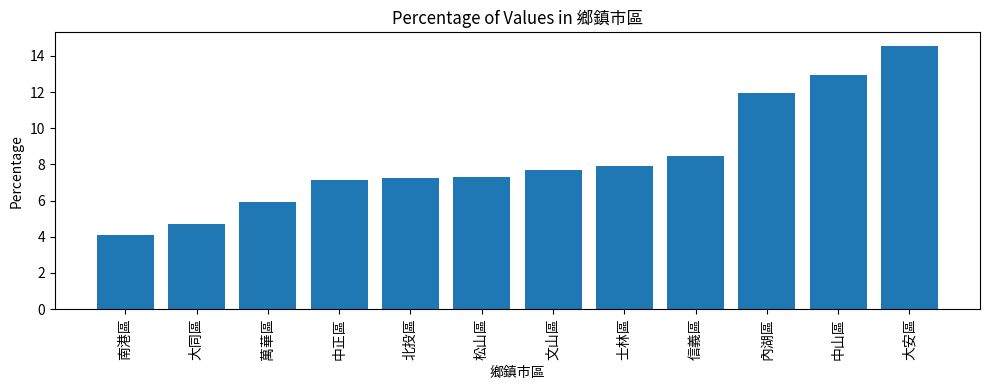

In [338]:
column_name = '鄉鎮市區'

# Calculate the value counts and percentages
value_counts = train_台北市[column_name].value_counts()
percentages = (value_counts / len(train_台北市)) * 100

# Create a DataFrame to display the results
value_percentage_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percentages.values})

# Sort the DataFrame by percentage in descending order
value_percentage_df = value_percentage_df.sort_values(by='Percentage', ascending=True)

plt.figure(figsize=(10, 4))  # Adjust the figure size if needed
plt.bar(value_percentage_df['Value'], value_percentage_df['Percentage'])
plt.xlabel(column_name)
plt.ylabel('Percentage')
plt.title(f'Percentage of Values in {column_name}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure boundaries

# Show the plot
#plt.show()

In [339]:
#plot_mean_and_median(train_台北市, '鄉鎮市區')

In [340]:


五 = ["台北市_大安區"]
四 = ["台北市_中正區", "台北市_松山區", "台北市_信義區", "台北市_中山區"]
三 = ["台北市_南港區"]
二 = ["台北市_內湖區", "台北市_士林區", "台北市_大同區",]
一 = ["台北市_北投區", "台北市_萬華區", "台北市_文山區"]

for index, row in train_台北市.iterrows():
    if row["縣市_鄉鎮市區"] in 五:
        train_台北市.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train_台北市.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train_台北市.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train_台北市.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train_台北市.at[index, "縣市_鄉鎮市區"] = "1"

* Feature Generation 台北市

In [341]:

feature_generation_台北市 = Pipeline([
    #('create_縣市_鄉鎮市區_路名', CombineColumnsTransformer(['縣市', '鄉鎮市區', '路名'], '縣市_鄉鎮市區_路名')),
    #('create_縣市_鄉鎮市區', CombineColumnsTransformer(['縣市', '鄉鎮市區'], '縣市_鄉鎮市區')),
    ('merge_with_web_scraping_data', MergeData(data_to_merge=grouped_data_2018_2020,on_column="縣市_鄉鎮市區",how="left")),
    ('encoding_縣市_鄉鎮市區', MapValuesTransformer('縣市_鄉鎮市區', encoding_縣市_鄉鎮市區)),
    ('grouping_主要建材', MapValuesTransformer('主要建材', material_mapping)),
    #('主要用途_mapping', MapValuesTransformer2('主要用途', 主要用途_mapping)),
    ('coordinate_converter', CoordinateConverter()),
    #('create_region', create_region()),
    ('calculate_總面積', CalculateTotalArea()),
    #('calculate_面積占比', CalculateAreaRatios()),
    #('calculate_鄉鎮市區加總', CalculateCountyArea()),
    #('calculate_房屋佔比鄉鎮市區',CalculateCountyAreaRatio()),
    #('calculate_坪數', CalculateSquareFeet()),
    #('calculate_土地面積', CalculateLandArea()),
    #('calculate_鄉鎮市區均值中位數', CalculateMeanMedianCountyArea(groupby_column = '縣市_鄉鎮市區')),
    #('create_直轄市', CreateDirectControlCityColumn()),
    #('calculate_floor_ratio', CalculateFloorRatio()),
    #('aggregate_floor_ratio', AggregateFloorRatio()),
    #('calculate_total_floors', CalculateTotalFloors()),
    #('calculate_relative_floor_ratio', CalculateRelativeFloorRatio()),
    ('identify_top_floor', IdentifyTopFloor()),
    #('calculate_total_floor_mean', CalculateTotalFloorMean()),
    #('calculate_total_floor_median', CalculateTotalFloorMedian()),
    ('extract_building_type', ExtractBuildingType()),
    ('extract_elevator_presence', ExtractElevatorPresence()),
    #('extract_additional_features', ExtractAdditionalFeatures()),
])

X_train_台北市 = train_raw_台北市.drop(columns=['單價'])
y_train_台北市 = train_raw_台北市['單價'].copy()
X_train_copy_台北市 = X_train_台北市.copy()

X_train_copy_台北市   = feature_generation_台北市 .fit_transform(X_train_copy_台北市 )
X_train_copy_台北市 .set_index(train_id_column_台北市 , inplace=True)
X_train_copy_台北市 .head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,總面積,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,其他,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,台北市_大安區_敦化南路二段,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,19.0,15.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,108.0,2.0,25538.0,4.04,23451.0,1.79,6.0,155.0,路,10,873438.842518,843247.52478,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,-0.809779,1,住宅大樓,1


* Feature Selection 台北市

In [342]:


#ID
id_col = ['鄉鎮市區', 'ID', '路名', '縣市']

#Missing to high
missing_col = missing_perc(X_train_copy_台北市, 99)#.index
print(len(missing_col.index))
missing_col.index


ref_or_dup_col = ["建物型態"]

drop_col_台北市 = id_col + missing_col.index.tolist() + one_uniq_col + ref_or_dup_col 

X_train_copy_台北市 = X_train_copy_台北市.drop(columns=drop_col_台北市, axis = 1)

11


In [343]:
drop_col_台北市

['鄉鎮市區',
 'ID',
 '路名',
 '縣市',
 '備註',
 '高度壞地標數',
 '中度壞地標數',
 '輕度壞地標數',
 'bad_score',
 '公園圖書館',
 'Y',
 'V',
 'C',
 'R_Kao',
 'O_Kao',
 '建物型態']

In [344]:
uncorrelated_factors_台北市  = trimm_correlated(X_train_copy_台北市 , 0.95)
uncorrelated_factors_台北市 .shape
uncorrelated_factors_台北市 .columns.tolist()
X_train_copy_num_台北市  = uncorrelated_factors_台北市 

num_feature_台北市 = X_train_copy_num_台北市 .columns.tolist()
cat_feature_台北市 = X_train_copy_台北市.select_dtypes(include='object').columns.tolist()
feature_selected_台北市  = X_train_copy_台北市[num_feature_台北市  + cat_feature_台北市 ]

(46, 46)


In [345]:
X_train_columns_台北市 = set(X_train_copy_台北市.columns)
feature_selected_columns_台北市 = set(feature_selected_台北市.columns)


columns_not_in_feature_selected_台北市 = X_train_columns_台北市 - feature_selected_columns_台北市


columns_not_in_feature_selected_list_台北市 = list(columns_not_in_feature_selected_台北市)


print(columns_not_in_feature_selected_list_台北市)

['web總價元_median_2018_2020', '權重_高中', '權重_國中', '權重', 'web單價元坪_median_2018_2020', 'long', '學生教職員總人數_國中', 'lat']


In [346]:
X_train_copy_台北市.columns

Index(['土地面積', '使用分區', '移轉層次', '總樓層數', '主要用途', '主要建材', '屋齡', '建物面積', '車位面積',
       '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積', '附屬建物面積', '縣市_鄉鎮市區_路名', '站點數',
       '金融機構數', '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'R_TPE', 'O_TPE', 'BR',
       'BL', 'A', 'G', 'ATM數', '郵局數', '學生教職員總人數_國中', '權重_國中', '學生教職員總人數_高中',
       '權重_高中', '車站級別', 'positive_clinic_數', '路_level', '縣市_鄉鎮市區',
       'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020',
       'web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020',
       'web總價元_mean_2018_2020', 'web總價元_median_2018_2020',
       'web總價元_max_2018_2020', 'web總價元_min_2018_2020', 'long', 'lat', '總面積',
       '頂樓', '建物型態2', '電梯'],
      dtype='object')

In [347]:
drop_col_台北市

['鄉鎮市區',
 'ID',
 '路名',
 '縣市',
 '備註',
 '高度壞地標數',
 '中度壞地標數',
 '輕度壞地標數',
 'bad_score',
 '公園圖書館',
 'Y',
 'V',
 'C',
 'R_Kao',
 'O_Kao',
 '建物型態']

* Preprocessing 台北市

In [348]:


#Category Features
cat_台北市 = X_train_copy_台北市.select_dtypes(include='object')

num_台北市 = X_train_copy_台北市.select_dtypes(np.number)

cat_cols_台北市 = ['使用分區', 
                '主要用途', 
                '主要建材', '建物型態2', '縣市_鄉鎮市區_路名', '路_level']

grouping_input_column_台北市 = ['縣市_鄉鎮市區', '站點數', '金融機構數', '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'ATM數', '郵局數', '學生教職員總人數_國中', '權重_國中',
                         '學生教職員總人數_高中', '權重_高中', 'positive_clinic_數'
                         #'positive_medical_staff_count', '權重_醫療'
                         ]


to_fill_zero_column_台北市 = ['R_TPE', 'O_TPE', 
                       'BR', 
                       'BL', 'A', 'G'
                        ]

主要建材_mapping = [['鋼筋混凝土加強磚造', '其他', '鋼骨造']]
cat_transformer_台北市= make_column_transformer(
    (OrdinalEncoder(categories=主要建材_mapping), ['主要建材']),
    (OrdinalEncoder(categories=路_level_mapping ), ['路_level']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市_鄉鎮市區_路名']),
    (OneHotEncoder(handle_unknown="ignore"), ['主要用途']),
    (OneHotEncoder(handle_unknown="ignore"), ['建物型態2'])
)

grouping_imputer_台北市 = Pipeline([ 
     ('bus_station_imputer', bus_station_imputer),
     ('finance_imputer', finance_imputer),
     ('elementry_imputer_學生教職員總人數', elementry_imputer_學生教職員總人數),
     ('elementry_imputer_權重', elementry_imputer_權重),
     ('store_imputer_超商', store_imputer_超商),
     ('store_imputer_全聯', store_imputer_全聯),
     ('atm_Inputer', atm_Inputer),
     ('postoffice_inputer', postoffice_inputer),
     ('junior_imputer_學生教職員總人數', junior_imputer_學生教職員總人數),
     ('junior_imputer_權重', junior_imputer_權重),
     ('highschool_imputer_學生教職員總人數', highschool_imputer_學生教職員總人數),
     ('highschool_imputer_權重', highschool_imputer_權重),
     #('positive_clinic_imputer_staff_count', positive_clinic_imputer_staff_count),
     #('positive_clinic_imputer_權重_醫療', positive_clinic_imputer_權重_醫療),
     ('positive_clinic_數_inputer', positive_clinic_數_inputer),
     ('trim_hogh_corr', TrimCorrelated(0.95)),
                            
    #('standardization', StandardScaler()),
    #('log_transform', log_transformer)
])

In [349]:
num_data_after_grouping_imputer_台北市 = grouping_imputer_台北市.fit_transform(X_train_copy_台北市)

In [350]:
left_missing_values_台北市 = num_data_after_grouping_imputer_台北市.isna().sum()

# Filter columns with missing values
columns_with_missing_values_台北市 = left_missing_values_台北市[left_missing_values_台北市 > 0]

# Print the columns with missing values
print(columns_with_missing_values_台北市)

R_TPE    1026
O_TPE    1026
BR       1026
BL       1026
A        1026
G        1026
dtype: int64


In [351]:
preprocessing_台北市 = ColumnTransformer(
    transformers=[
        ("categorical", cat_transformer_台北市, cat_cols_台北市),
        ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["lat", "long"]), #This is another feature generation
        ('stationlevel_imputer', stationlevel_imputer, ["車站級別"]),
        ('fill_zero_imputer', fill_zero_imputer, to_fill_zero_column_台北市), 
        ('grouping_imputer', grouping_imputer_台北市, grouping_input_column_台北市),
    ],
      remainder="passthrough")  
preprocessed_台北市 = preprocessing_台北市.fit_transform(X_train_copy_台北市)

In [352]:
preprocessed_台北市.shape

(2382, 601)

* 台北市 RF Pipeline 

In [353]:
pipeline_test_rf_台北市 = Pipeline([
    ('feature_generation', feature_generation_台北市), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_台北市)),
    ('preprocessing', preprocessing_台北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("rf2", RandomForestRegressor(random_state=42)),
])

In [354]:
qt = QuantileTransformer(output_distribution="normal")
pipeline_test_rf_台北市 = TransformedTargetRegressor(regressor=pipeline_test_rf_台北市, transformer=qt)
cross_val_score(pipeline_test_rf_台北市, X_train_台北市, y_train_台北市, scoring=nmape_scorer, cv=3)

array([-7.27239325, -8.00690657, -7.75751517])

In [355]:
pipeline_test_rf_台北市.fit(X_train_台北市 , y_train_台北市 )

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                                                        FillMissingByCategory(column_to_fill='positive_clinic_數',
                                                                                                                              grouping_column='縣市_鄉鎮市區',
                                                                                                                              method='median')),
                                                                                                       ('trim_hogh_corr',
                                                                                                        TrimCorrelated(threshold=0.95))]),
                                                                                       ['縣市_鄉鎮市區',
                                                                                        '站點數',
                                                                                        '金融機構數',
                                                                                        '學生教職員總人數',
                                                                                        '權重',
                                                                                        '附近超商數',
                                                                                        '附近全聯數',
                                                                                        'ATM數',
                                                                                        '郵局數',
                                                                                        '學生教職員總人數_國中',
                                                                                        '權重_國中',
                                                                                        '學生教職員總人數_高中',
                                                                                        '權重_高中',
                                                                                        'positive_clinic_數'])])),
                                                     ('rf2',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

---

新北市

In [356]:
train_raw_新北市  = train_新北市 .copy()#Save the raw data that may use later

test_id_column_新北市  = test_新北市 ['ID']
train_id_column_新北市  = train_新北市 ['ID']  # Store the "ID" column in a separate variable
train_新北市 .set_index("ID", inplace=True)

X_train_新北市  = train_新北市 .drop(columns=['單價'])
y_train_新北市  = train_新北市 ['單價'].copy()

test_id_column_新北市  = test_新北市['ID']

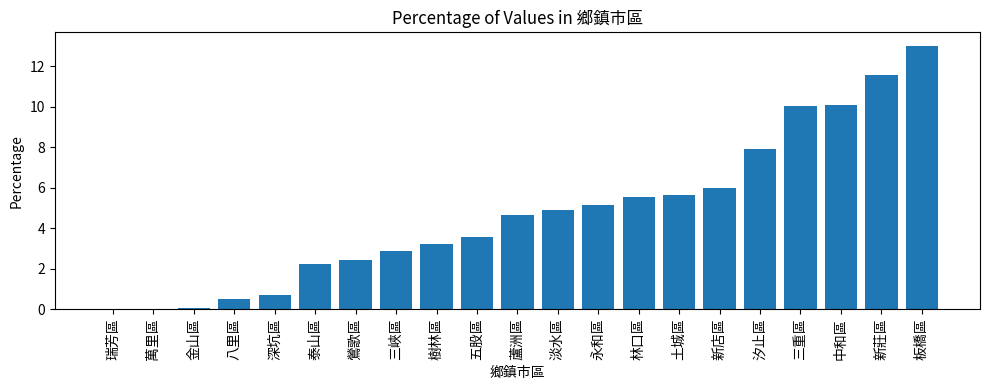

In [357]:
column_name = '鄉鎮市區'

# Calculate the value counts and percentages
value_counts = train_新北市[column_name].value_counts()
percentages = (value_counts / len(train_新北市)) * 100

# Create a DataFrame to display the results
value_percentage_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percentages.values})

# Sort the DataFrame by percentage in descending order
value_percentage_df = value_percentage_df.sort_values(by='Percentage', ascending=True)

plt.figure(figsize=(10, 4))  # Adjust the figure size if needed
plt.bar(value_percentage_df['Value'], value_percentage_df['Percentage'])
plt.xlabel(column_name)
plt.ylabel('Percentage')
plt.title(f'Percentage of Values in {column_name}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure boundaries

# Show the plot
#plt.show()

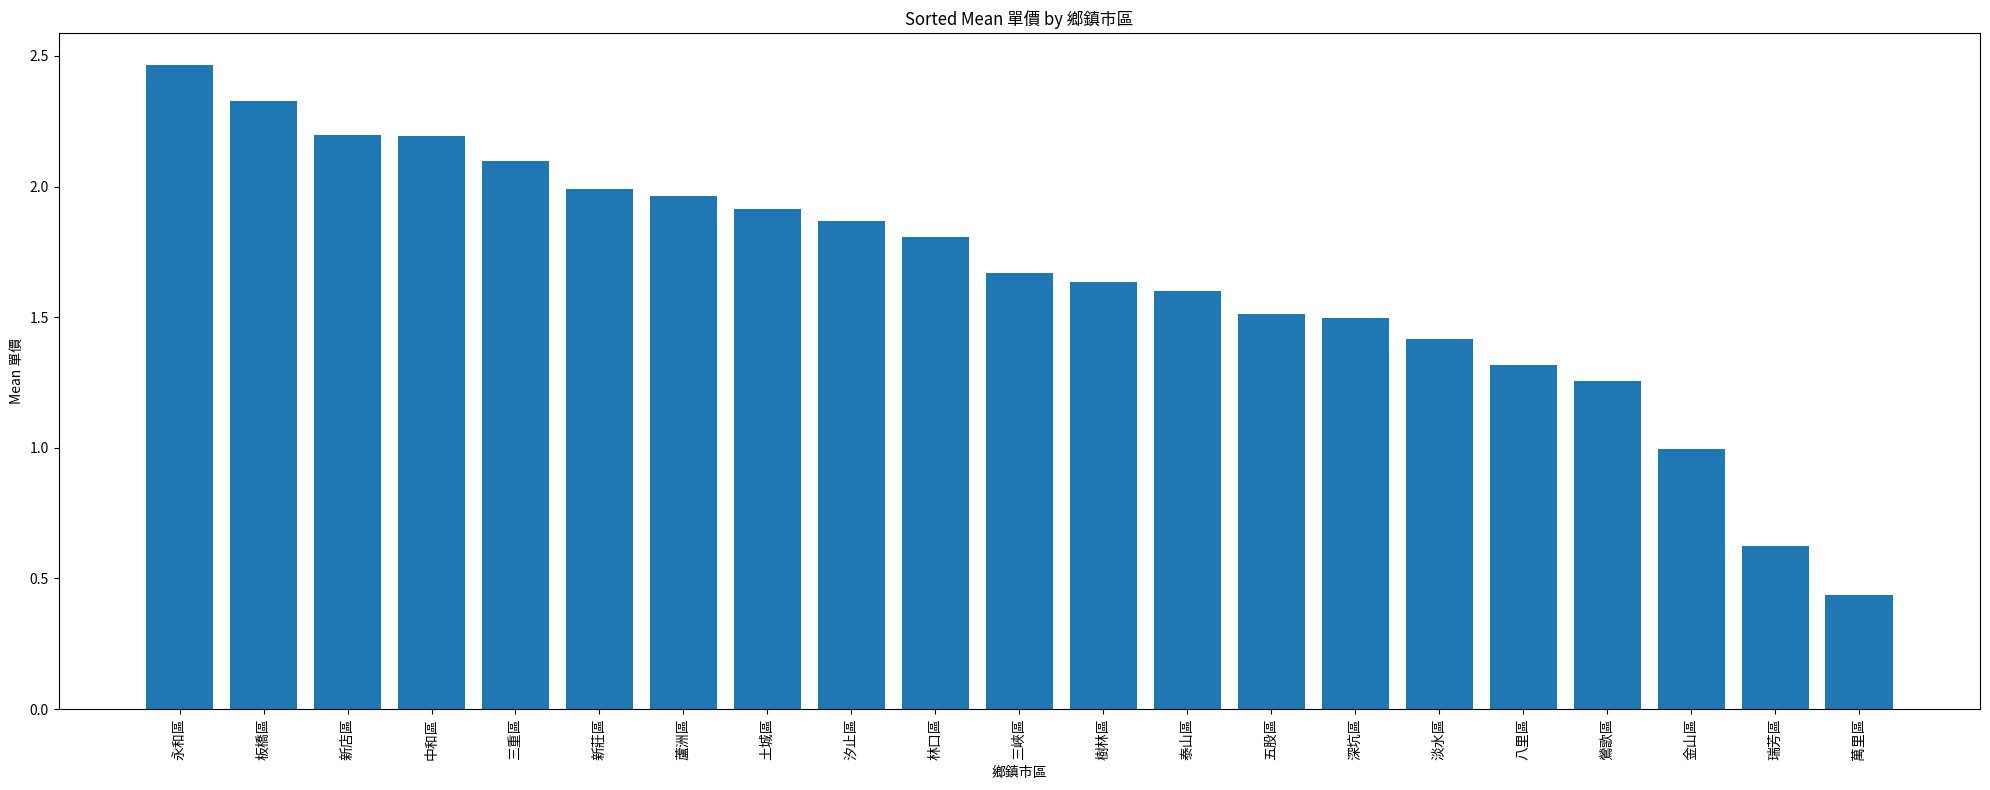

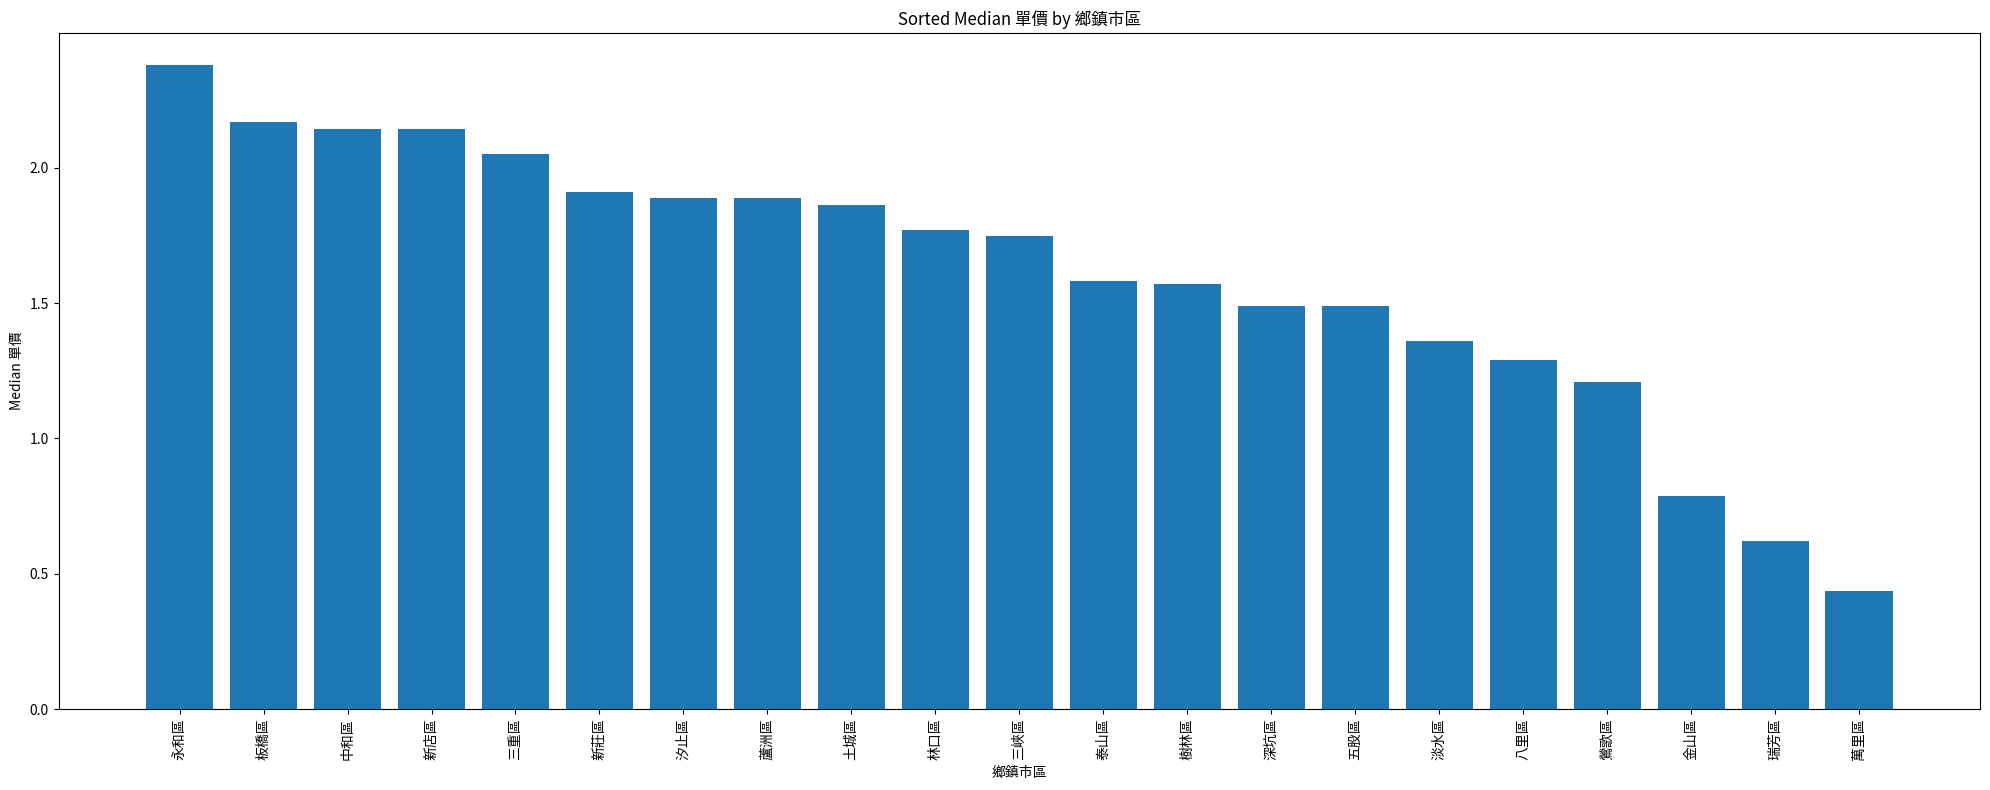

In [358]:
plot_mean_and_median(train_新北市, '鄉鎮市區')

In [359]:

五 = ["新北市_永和區", "新北市_板橋區", "新北市_中和區", "新北市_新店區", "新北市_三重區"]
四 = ["新北市_新莊區", "新北市_蘆洲區", "新北市_土城區", "新北市_汐止區", "新北市_林口區", "新北市_三峽區", "新北市_坪林區", "新北市_平溪區"]
三 = ["新北市_泰山區", "新北市_樹林區", "新北市_深坑區", "新北市_五股區"]
二 = ["新北市_淡水區", "新北市_八里區", "新北市_鶯歌區"]
一 = ["新北市_金山區", "新北市_瑞芳區", "新北市_萬里區"]

for index, row in train_新北市.iterrows():
    if row["縣市_鄉鎮市區"] in 五:
        train_新北市.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train_新北市.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train_新北市.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train_新北市.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train_新北市.at[index, "縣市_鄉鎮市區"] = "1"
        
        

In [360]:
feature_generation_新北市 = Pipeline([
    #('create_縣市_鄉鎮市區_路名', CombineColumnsTransformer(['縣市', '鄉鎮市區', '路名'], '縣市_鄉鎮市區_路名')),
    #('create_縣市_鄉鎮市區', CombineColumnsTransformer(['縣市', '鄉鎮市區'], '縣市_鄉鎮市區')),
    ('merge_with_web_scraping_data', MergeData(data_to_merge=grouped_data_2018_2020,on_column="縣市_鄉鎮市區",how="left")),
    ('encoding_縣市_鄉鎮市區', MapValuesTransformer('縣市_鄉鎮市區', encoding_縣市_鄉鎮市區)),
    ('grouping_主要建材', MapValuesTransformer('主要建材', material_mapping)),
    #('主要用途_mapping', MapValuesTransformer2('主要用途', 主要用途_mapping)),
    ('coordinate_converter', CoordinateConverter()),
    #('create_region', create_region()),
    ('calculate_總面積', CalculateTotalArea()),
    #('calculate_面積占比', CalculateAreaRatios()),
    #('calculate_鄉鎮市區加總', CalculateCountyArea()),
    #('calculate_房屋佔比鄉鎮市區',CalculateCountyAreaRatio()),
    #('calculate_坪數', CalculateSquareFeet()),
    #('calculate_土地面積', CalculateLandArea()),
    #('calculate_鄉鎮市區均值中位數', CalculateMeanMedianCountyArea(groupby_column = '縣市_鄉鎮市區')),
    #('create_直轄市', CreateDirectControlCityColumn()),
    #('calculate_floor_ratio', CalculateFloorRatio()),
    #('aggregate_floor_ratio', AggregateFloorRatio()),
    #('calculate_total_floors', CalculateTotalFloors()),
    #('calculate_relative_floor_ratio', CalculateRelativeFloorRatio()),
    ('identify_top_floor', IdentifyTopFloor()),
    #('calculate_total_floor_mean', CalculateTotalFloorMean()),
    #('calculate_total_floor_median', CalculateTotalFloorMedian()),
    ('extract_building_type', ExtractBuildingType()),
    ('extract_elevator_presence', ExtractElevatorPresence()),
    #('extract_additional_features', ExtractAdditionalFeatures()),
])

X_train_新北市 = train_raw_新北市.drop(columns=['單價'])
y_train_新北市 = train_raw_新北市['單價'].copy()
X_train_copy_新北市 = X_train_新北市.copy()

X_train_copy_新北市  = feature_generation_新北市 .fit_transform(X_train_copy_新北市)
X_train_copy_新北市 .set_index(train_id_column_新北市 , inplace=True)
X_train_copy_新北市 .head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,總面積,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-4,TR-4,新北市,新莊區,福前街,0.085594,None,9,14,集合住宅,其他,住宅大樓(11層含以上有電梯),8.833333,0.164249,0.524653,1.0,296653,2772355,NaN,-0.071147,0.315088,0.231984,新北市_新莊區_福前街,209.0,NaN,NaN,NaN,NaN,3.0,15.0,32882.0,8.8,11.0,12.0,0.0,0.0,NaN,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,55.0,1.0,16333.0,2.89,11790.0,0.93,6.0,25.0,街,8,372336.120189,376982.37423,634420.77048,113735.70495,1.480026e+07,13000000.0,37060000,500000,121.462402,25.058663,1.00399,0,住宅大樓,1


In [361]:
#ID
id_col = ['鄉鎮市區', 'ID', '路名', '縣市']

#Missing to high
missing_col = missing_perc(X_train_copy_新北市, 99)#.index
print(len(missing_col.index))
missing_col.index


ref_or_dup_col = ["建物型態"]

drop_col_新北市 = id_col + missing_col.index.tolist() + one_uniq_col + ref_or_dup_col 

X_train_copy_新北市 = X_train_copy_新北市.drop(columns=drop_col_新北市, axis = 1)

5


In [362]:
drop_col_新北市

['鄉鎮市區', 'ID', '路名', '縣市', '備註', 'BR', 'C', 'R_Kao', 'O_Kao', '建物型態']

In [363]:
#Category Features
cat_新北市 = X_train_copy_新北市.select_dtypes(include='object')

num_新北市= X_train_copy_新北市.select_dtypes(np.number)

cat_cols_新北市 = ['使用分區', 
                '主要用途', 
                '主要建材', '建物型態2', '縣市_鄉鎮市區_路名', '路_level']

grouping_input_column_新北市 = ['縣市_鄉鎮市區', '站點數', '金融機構數', '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'ATM數', '郵局數', '學生教職員總人數_國中', '權重_國中',
                         '學生教職員總人數_高中', '權重_高中', 'positive_clinic_數'
                         #'positive_medical_staff_count', '權重_醫療'
                         ]


to_fill_zero_column_新北市 = ['R_TPE', 'O_TPE', 
                       #'BR', 
                       '高度壞地標數', '中度壞地標數', '輕度壞地標數',
                       'BL', 'A', 'G', 'Y', 'V',
                       '公園圖書館', 'bad_score'
                        ]

主要建材_mapping = [['鋼筋混凝土加強磚造', '其他', '鋼骨造']]
cat_transformer_新北市= make_column_transformer(
    (OrdinalEncoder(categories=主要建材_mapping), ['主要建材']),
    (OrdinalEncoder(categories=路_level_mapping ), ['路_level']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市_鄉鎮市區_路名']),
    (OneHotEncoder(handle_unknown="ignore"), ['主要用途']),
    (OneHotEncoder(handle_unknown="ignore"), ['建物型態2'])
)

grouping_imputer_新北市 = Pipeline([ 
     ('bus_station_imputer', bus_station_imputer),
     ('finance_imputer', finance_imputer),
     ('elementry_imputer_學生教職員總人數', elementry_imputer_學生教職員總人數),
     ('elementry_imputer_權重', elementry_imputer_權重),
     ('store_imputer_超商', store_imputer_超商),
     ('store_imputer_全聯', store_imputer_全聯),
     ('atm_Inputer', atm_Inputer),
     ('postoffice_inputer', postoffice_inputer),
     ('junior_imputer_學生教職員總人數', junior_imputer_學生教職員總人數),
     ('junior_imputer_權重', junior_imputer_權重),
     ('highschool_imputer_學生教職員總人數', highschool_imputer_學生教職員總人數),
     ('highschool_imputer_權重', highschool_imputer_權重),
     #('positive_clinic_imputer_staff_count', positive_clinic_imputer_staff_count),
     #('positive_clinic_imputer_權重_醫療', positive_clinic_imputer_權重_醫療),
     ('positive_clinic_數_inputer', positive_clinic_數_inputer),
     ('trim_hogh_corr', TrimCorrelated(0.95)),
                            
    #('standardization', StandardScaler()),
    #('log_transform', log_transformer)
])

In [364]:
num_data_after_grouping_imputer_新北市 = grouping_imputer_新北市.fit_transform(X_train_copy_新北市)

In [365]:
left_missing_values_新北市 = num_data_after_grouping_imputer_新北市.isna().sum()

# Filter columns with missing values
columns_with_missing_values_新北市 = left_missing_values_新北市[left_missing_values_新北市 > 0]

# Print the columns with missing values
print(columns_with_missing_values_新北市)

高度壞地標數       1883
中度壞地標數       1883
輕度壞地標數       1883
bad_score    1883
公園圖書館        983 
R_TPE        2906
O_TPE        2906
BL           2906
A            2906
G            2906
Y            2906
V            4169
dtype: int64


In [366]:
preprocessing_新北市 = ColumnTransformer(
    transformers=[
        ("categorical", cat_transformer_新北市, cat_cols_新北市),
        ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["lat", "long"]), #This is another feature generation
        ('stationlevel_imputer', stationlevel_imputer, ["車站級別"]),
        ('fill_zero_imputer', fill_zero_imputer, to_fill_zero_column_新北市), 
        ('grouping_imputer', grouping_imputer_新北市, grouping_input_column_新北市),
    ],
      remainder="passthrough")  
preprocessed_新北市 = preprocessing_新北市.fit_transform(X_train_copy_新北市)

In [367]:
pipeline_test_rf_新北市 = Pipeline([
    ('feature_generation', feature_generation_新北市 ), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_新北市 )),
    ('preprocessing', preprocessing_新北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("rf2", RandomForestRegressor(random_state=42)),
])

In [368]:
qt = QuantileTransformer(output_distribution="normal")
pipeline_test_rf_新北市 = TransformedTargetRegressor(regressor=pipeline_test_rf_新北市, transformer=qt)
cross_val_score(pipeline_test_rf_新北市, X_train_新北市, y_train_新北市, scoring=nmape_scorer, cv=3)

c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_target.py", line 262, in fit
    self.regressor_.fit(X, y_trans, **fit_params)
  File "c:\Users\Jonathan\AppData\Local\Programs\Python\Python311\L

array([        nan, -6.74417072, -6.46766418])

In [369]:
pipeline_test_rf_新北市.fit(X_train_新北市 , y_train_新北市 )

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                                                        FillMissingByCategory(column_to_fill='positive_clinic_數',
                                                                                                                              grouping_column='縣市_鄉鎮市區',
                                                                                                                              method='median')),
                                                                                                       ('trim_hogh_corr',
                                                                                                        TrimCorrelated(threshold=0.95))]),
                                                                                       ['縣市_鄉鎮市區',
                                                                                        '站點數',
                                                                                        '金融機構數',
                                                                                        '學生教職員總人數',
                                                                                        '權重',
                                                                                        '附近超商數',
                                                                                        '附近全聯數',
                                                                                        'ATM數',
                                                                                        '郵局數',
                                                                                        '學生教職員總人數_國中',
                                                                                        '權重_國中',
                                                                                        '學生教職員總人數_高中',
                                                                                        '權重_高中',
                                                                                        'positive_clinic_數'])])),
                                                     ('rf2',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

---

## 非台北市

In [370]:
train_raw_非台北市  = train_非台北市 .copy()#Save the raw data that may use later

test_id_column_非台北市  = test_非台北市 ['ID']
train_id_column_非台北市  = train_非台北市 ['ID']  # Store the "ID" column in a separate variable
train_非台北市 .set_index("ID", inplace=True)

X_train_非台北市  = train_非台北市 .drop(columns=['單價'])
y_train_非台北市  = train_非台北市 ['單價'].copy()

test_id_column_非台北市  = test_非台北市['ID']

In [371]:
八 = ["新竹縣_竹北市"]
七 = ["苗栗縣_泰安鄉", "台中市_和平區", "台中市_南屯區", "南投縣_仁愛鄉", "台中市_西屯區"]
六 = ["高雄市_前金區", "高雄市_鼓山區", "桃園市_桃園區", "桃園市_龜山區", "宜蘭縣_頭城鎮", "台中市_北屯區", "新竹市_新竹市", "台中市_烏日區", "台中市_西區", "桃園市_蘆竹區", "高雄市_仁武區", "高雄市_苓雅區", "新北市_八里區", "台中市_神岡區", "高雄市_左營區", "台中市_東區", "桃園市_大園區", "台中市_豐原區", "金門縣_金城鎮", "台中市_大雅區", "台中市_北區", "台中市_后里區", "新竹縣_新埔鎮", "台中市_南區", "台中市_太平區", "桃園市_中壢區", "宜蘭縣_礁溪鄉", "台中市_沙鹿區", "台中市_大里區", "金門縣_金湖鎮", "台中市_潭子區"]
五 = grouped_data.query("單價元坪_median <= 200000 & 單價元坪_median > 175000")["縣市_鄉鎮市區"].tolist()
四 = grouped_data.query("單價元坪_median <= 175000 & 單價元坪_median > 150000")["縣市_鄉鎮市區"].tolist()
三 = grouped_data.query("單價元坪_median <= 150000 & 單價元坪_median > 100000")["縣市_鄉鎮市區"].tolist()
二 = grouped_data.query("單價元坪_median <= 100000 & 單價元坪_median > 50000")["縣市_鄉鎮市區"].tolist()
一 = grouped_data.query("單價元坪_median <= 50000")["縣市_鄉鎮市區"].tolist()

for index, row in train_非台北市.iterrows():
    if row["縣市_鄉鎮市區"] in 八:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "8"
    elif row["縣市_鄉鎮市區"] in 七:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "7"
    elif row["縣市_鄉鎮市區"] in 六:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "6"
    elif row["縣市_鄉鎮市區"] in 五:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "1"

In [372]:

'''
八 = ["新北市_永和區", "新北市_板橋區", "新北市_中和區", "新北市_新店區", "新北市_三重區", "新北市_新莊區", "新北市_蘆洲區", "新北市_土城區", "新北市_汐止區", "新北市_坪林區", "新竹縣_竹北市", "新北市_平溪區", "新北市_汐止區"]
七 = ["新北市_泰山區", "新北市_林口區", "新北市_五股區", "新北市_樹林區", "新北市_深坑區", "新北市_三峽區", "苗栗縣_泰安鄉", "台中市_和平區", "台中市_南屯區", "南投縣_仁愛鄉", "台中市_西屯區"]
六 = ["高雄市_前金區", "高雄市_鼓山區", "桃園市_桃園區", "新北市_淡水區", "桃園市_龜山區", "宜蘭縣_頭城鎮", "台中市_北屯區", "新竹市_新竹市", "台中市_烏日區", "台中市_西區", "新北市_鶯歌區", "桃園市_蘆竹區", "高雄市_仁武區", "高雄市_苓雅區", "新北市_八里區", "台中市_神岡區", "高雄市_左營區", "台中市_東區", "桃園市_大園區", "台中市_豐原區", "金門縣_金城鎮", "台中市_大雅區", "台中市_北區", "台中市_后里區", "新竹縣_新埔鎮", "台中市_南區", "台中市_太平區", "桃園市_中壢區", "宜蘭縣_礁溪鄉", "台中市_沙鹿區", "台中市_大里區", "金門縣_金湖鎮", "台中市_潭子區"]
五 = grouped_data.query("單價元坪_median <= 200000 & 單價元坪_median > 175000")["縣市_鄉鎮市區"].tolist()
四 = grouped_data.query("單價元坪_median <= 175000 & 單價元坪_median > 150000")["縣市_鄉鎮市區"].tolist()
三 = grouped_data.query("單價元坪_median <= 150000 & 單價元坪_median > 100000")["縣市_鄉鎮市區"].tolist()
二 = grouped_data.query("單價元坪_median <= 100000 & 單價元坪_median > 50000")["縣市_鄉鎮市區"].tolist()
一 = grouped_data.query("單價元坪_median <= 50000")["縣市_鄉鎮市區"].tolist()

for index, row in train_非台北市.iterrows():
    if row["縣市_鄉鎮市區"] in 八:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "8"
    elif row["縣市_鄉鎮市區"] in 七:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "7"
    elif row["縣市_鄉鎮市區"] in 六:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "6"
    elif row["縣市_鄉鎮市區"] in 五:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train_非台北市.at[index, "縣市_鄉鎮市區"] = "1"
        
        '''

'\n八 = ["新北市_永和區", "新北市_板橋區", "新北市_中和區", "新北市_新店區", "新北市_三重區", "新北市_新莊區", "新北市_蘆洲區", "新北市_土城區", "新北市_汐止區", "新北市_坪林區", "新竹縣_竹北市", "新北市_平溪區", "新北市_汐止區"]\n七 = ["新北市_泰山區", "新北市_林口區", "新北市_五股區", "新北市_樹林區", "新北市_深坑區", "新北市_三峽區", "苗栗縣_泰安鄉", "台中市_和平區", "台中市_南屯區", "南投縣_仁愛鄉", "台中市_西屯區"]\n六 = ["高雄市_前金區", "高雄市_鼓山區", "桃園市_桃園區", "新北市_淡水區", "桃園市_龜山區", "宜蘭縣_頭城鎮", "台中市_北屯區", "新竹市_新竹市", "台中市_烏日區", "台中市_西區", "新北市_鶯歌區", "桃園市_蘆竹區", "高雄市_仁武區", "高雄市_苓雅區", "新北市_八里區", "台中市_神岡區", "高雄市_左營區", "台中市_東區", "桃園市_大園區", "台中市_豐原區", "金門縣_金城鎮", "台中市_大雅區", "台中市_北區", "台中市_后里區", "新竹縣_新埔鎮", "台中市_南區", "台中市_太平區", "桃園市_中壢區", "宜蘭縣_礁溪鄉", "台中市_沙鹿區", "台中市_大里區", "金門縣_金湖鎮", "台中市_潭子區"]\n五 = grouped_data.query("單價元坪_median <= 200000 & 單價元坪_median > 175000")["縣市_鄉鎮市區"].tolist()\n四 = grouped_data.query("單價元坪_median <= 175000 & 單價元坪_median > 150000")["縣市_鄉鎮市區"].tolist()\n三 = grouped_data.query("單價元坪_median <= 150000 & 單價元坪_median > 100000")["縣市_鄉鎮市區"].tolist()\n二 = grouped_data.query("單價元坪_median <= 100000 & 單價元坪_median > 50000")["縣市_鄉鎮市區"]

* feature generation 非台北市

In [373]:
#Feature Generation
feature_generation_非台北市 = Pipeline([
    #('create_縣市_鄉鎮市區_路名', CombineColumnsTransformer(['縣市', '鄉鎮市區', '路名'], '縣市_鄉鎮市區_路名')),
    #('create_縣市_鄉鎮市區', CombineColumnsTransformer(['縣市', '鄉鎮市區'], '縣市_鄉鎮市區')),
    ('merge_with_web_scraping_data', MergeData(data_to_merge=grouped_data_2018_2020,on_column="縣市_鄉鎮市區",how="left")),
    ('encoding_縣市_鄉鎮市區', MapValuesTransformer('縣市_鄉鎮市區', encoding_縣市_鄉鎮市區)),
    ('grouping_主要建材', MapValuesTransformer('主要建材', material_mapping)),
    #('主要用途_mapping', MapValuesTransformer2('主要用途', 主要用途_mapping)),
    ('coordinate_converter', CoordinateConverter()),
    ('create_region', create_region()),
    ('calculate_總面積', CalculateTotalArea()),
    #('calculate_面積占比', CalculateAreaRatios()),
    #('calculate_鄉鎮市區加總', CalculateCountyArea()),
    #('calculate_房屋佔比鄉鎮市區',CalculateCountyAreaRatio()),
    #('calculate_坪數', CalculateSquareFeet()),
    #('calculate_土地面積', CalculateLandArea()),
    #('calculate_鄉鎮市區均值中位數', CalculateMeanMedianCountyArea(groupby_column = '縣市_鄉鎮市區')),
    ('create_直轄市', CreateDirectControlCityColumn()),
    #('calculate_floor_ratio', CalculateFloorRatio()),
    #('aggregate_floor_ratio', AggregateFloorRatio()),
    #('calculate_total_floors', CalculateTotalFloors()),
    #('calculate_relative_floor_ratio', CalculateRelativeFloorRatio()),
    ('identify_top_floor', IdentifyTopFloor()),
    #('calculate_total_floor_mean', CalculateTotalFloorMean()),
    #('calculate_total_floor_median', CalculateTotalFloorMedian()),
    ('extract_building_type', ExtractBuildingType()),
    ('extract_elevator_presence', ExtractElevatorPresence()),
    #('extract_additional_features', ExtractAdditionalFeatures()),
])

X_train_非台北市 = train_raw_非台北市.drop(columns=['單價'])
y_train_非台北市 = train_raw_非台北市['單價'].copy()
X_train_copy_非台北市 = X_train_非台北市.copy()

X_train_copy_非台北市   = feature_generation_非台北市 .fit_transform(X_train_copy_非台北市 )
X_train_copy_非台北市 .set_index(train_id_column_非台北市 , inplace=True)
X_train_copy_非台北市 .head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,縣市_鄉鎮市區_路名,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,附近超商數,附近全聯數,R_TPE,O_TPE,BR,BL,A,G,Y,V,C,R_Kao,O_Kao,ATM數,郵局數,學生教職員總人數_國中,權重_國中,學生教職員總人數_高中,權重_高中,車站級別,positive_clinic_數,路_level,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-3,TR-3,高雄市,鳳山區,北忠街,0.181921,None,10,15,集合住宅,其他,住宅大樓(11層含以上有電梯),6.166667,0.423366,0.161624,1.0,184815,2504666,NaN,-0.098871,-0.36062,1.525881,高雄市_鳳山區_北忠街,74.0,0.0,0.0,1.0,1.1,1.0,2.0,13359.0,4.5,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1.0,11711.0,1.8,7322.0,0.5,6.0,23.0,街,5,159582.786483,161130.81618,302053.33809,41560.39188,6.276418e+06,5780000.0,15700000,200000,120.365799,22.640966,南部,0.22437,municipality,0,住宅大樓,1


In [374]:
#Feature Selection

#ID
id_col = ['鄉鎮市區', 'ID', '路名']

#Missing to high
missing_col = missing_perc(X_train_copy_非台北市, 99)#.index
print(len(missing_col.index))
missing_col.index


ref_or_dup_col = ["建物型態", '備註']

drop_col_非台北市 = id_col + missing_col.index.tolist() + one_uniq_col + ref_or_dup_col 

X_train_copy_非台北市 = X_train_copy_非台北市.drop(columns=drop_col_非台北市, axis = 1)

7


In [375]:
drop_col_非台北市

['鄉鎮市區', 'ID', '路名', 'R_TPE', 'O_TPE', 'BR', 'BL', 'G', 'Y', 'V', '建物型態', '備註']

In [376]:
uncorrelated_factors_非台北市  = trimm_correlated(X_train_copy_非台北市 , 0.95)
uncorrelated_factors_非台北市 .shape
uncorrelated_factors_非台北市 .columns.tolist()
X_train_copy_num_非台北市  = uncorrelated_factors_非台北市 

num_feature_非台北市 = X_train_copy_num_非台北市 .columns.tolist()
cat_feature_非台北市 = X_train_copy_非台北市.select_dtypes(include='object').columns.tolist()
feature_selected_非台北市  = X_train_copy_非台北市[num_feature_非台北市  + cat_feature_非台北市 ]

(49, 49)


In [377]:
X_train_columns_非台北市 = set(X_train_copy_非台北市.columns)
feature_selected_columns_非台北市 = set(feature_selected_非台北市.columns)


columns_not_in_feature_selected_非台北市 = X_train_columns_非台北市 - feature_selected_columns_非台北市


columns_not_in_feature_selected_list_非台北市 = list(columns_not_in_feature_selected_非台北市)


print(columns_not_in_feature_selected_list_非台北市)

['權重_高中', '權重_國中', '權重', 'web單價元坪_median_2018_2020', 'long', 'lat', '主建物面積']


* preprocessing 非台北市

In [378]:
drop_col_非台北市

['鄉鎮市區', 'ID', '路名', 'R_TPE', 'O_TPE', 'BR', 'BL', 'G', 'Y', 'V', '建物型態', '備註']

In [379]:
#Category Features
cat_非台北市 = X_train_copy_非台北市.select_dtypes(include='object')

num_非台北市 = X_train_copy_非台北市.select_dtypes(np.number)

cat_cols_非台北市 = ['縣市', '使用分區', 
                 '主要用途', 
                 '主要建材', 'region', '直轄市', '建物型態2', '縣市_鄉鎮市區_路名', '路_level']

grouping_input_column_非台北市 = ['縣市_鄉鎮市區', '站點數', '金融機構數', '學生教職員總人數', '權重', '附近超商數', '附近全聯數', 'ATM數', '郵局數', '學生教職員總人數_國中', '權重_國中',
                         '學生教職員總人數_高中', '權重_高中', 'positive_clinic_數'
                         #'positive_medical_staff_count', '權重_醫療'
                         ]

to_fill_zero_column_非台北市 = ['高度壞地標數', '中度壞地標數', '輕度壞地標數', 'bad_score', '公園圖書館', 
                        #'R_TPE', 'O_TPE',  
                       #'BL', 'BR',
                       'A', 
                       #'G', 
                       #'Y',
                       #'V',
                       'C', 'R_Kao', 'O_Kao'
                        ]


region_mapping = [[ '東部','外島','南部', '中部','北部']]
cat_transformer_非台北市= make_column_transformer(
    (OrdinalEncoder(categories=主要建材_mapping), ['主要建材']),
    (OrdinalEncoder(categories=直轄市_mapping ), ['直轄市']),
    (OrdinalEncoder(categories=region_mapping ), ['region']),
    (OrdinalEncoder(categories=路_level_mapping ), ['路_level']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市_鄉鎮市區_路名']),
    (OneHotEncoder(handle_unknown="ignore"), ['主要用途']),
    (OneHotEncoder(handle_unknown="ignore"), ['建物型態2'])
)


grouping_imputer_非台北市 = Pipeline([ 
     ('bus_station_imputer', bus_station_imputer),
     ('finance_imputer', finance_imputer),
     ('elementry_imputer_學生教職員總人數', elementry_imputer_學生教職員總人數),
     ('elementry_imputer_權重', elementry_imputer_權重),
     ('store_imputer_超商', store_imputer_超商),
     ('store_imputer_全聯', store_imputer_全聯),
     ('atm_Inputer', atm_Inputer),
     ('postoffice_inputer', postoffice_inputer),
     ('junior_imputer_學生教職員總人數', junior_imputer_學生教職員總人數),
     ('junior_imputer_權重', junior_imputer_權重),
     ('highschool_imputer_學生教職員總人數', highschool_imputer_學生教職員總人數),
     ('highschool_imputer_權重', highschool_imputer_權重),
     #('positive_clinic_imputer_staff_count', positive_clinic_imputer_staff_count),
     #('positive_clinic_imputer_權重_醫療', positive_clinic_imputer_權重_醫療),
     ('positive_clinic_數_inputer', positive_clinic_數_inputer),
     ('trim_hogh_corr', TrimCorrelated(0.95)),
                            
    #('standardization', StandardScaler()),
    #('log_transform', log_transformer)
])

In [380]:
num_data_after_grouping_imputer_非台北市 = grouping_imputer_非台北市.fit_transform(X_train_copy_非台北市)

In [381]:
left_missing_values_非台北市 = num_data_after_grouping_imputer_非台北市.isna().sum()

# Filter columns with missing values
columns_with_missing_values_非台北市 = left_missing_values_非台北市[left_missing_values_非台北市 > 0]

# Print the columns with missing values
print(columns_with_missing_values_非台北市)

高度壞地標數       3994
中度壞地標數       3994
輕度壞地標數       3994
bad_score    3994
公園圖書館        2289
A            5004
C            4815
R_Kao        4792
O_Kao        4792
車站級別         5   
dtype: int64


In [382]:
cat_cols_非台北市

['縣市',
 '使用分區',
 '主要用途',
 '主要建材',
 'region',
 '直轄市',
 '建物型態2',
 '縣市_鄉鎮市區_路名',
 '路_level']

In [383]:
preprocessing_非台北市 = ColumnTransformer(
    transformers=[
        ("categorical", cat_transformer_非台北市, cat_cols_非台北市),
        ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["lat", "long"]), #This is another feature generation
        ('stationlevel_imputer', stationlevel_imputer, ["車站級別"]),
        ('fill_zero_imputer', fill_zero_imputer, to_fill_zero_column_非台北市), 
        ('grouping_imputer', grouping_imputer_非台北市, grouping_input_column_非台北市),
    ],
      remainder="passthrough")  
preprocessed_非台北市 = preprocessing_非台北市.fit_transform(X_train_copy_非台北市)

In [384]:
preprocessed_非台北市.shape

(5066, 2317)

In [385]:
pipeline_test_rf_非台北市 = Pipeline([
    ('feature_generation', feature_generation_非台北市), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_非台北市)),
    ('preprocessing', preprocessing_非台北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("rf2", RandomForestRegressor(random_state=42)),
])

In [386]:
qt = QuantileTransformer(output_distribution="normal")
pipeline_test_rf_非台北市 = TransformedTargetRegressor(regressor=pipeline_test_rf_非台北市, transformer=qt)
cross_val_score(pipeline_test_rf_非台北市, X_train_非台北市, y_train_非台北市, scoring=nmape_scorer, cv=3)

array([-9.8868246 , -8.96442362, -9.98351509])

In [387]:
pipeline_test_rf_非台北市.fit(X_train_非台北市 , y_train_非台北市 )

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                                                        FillMissingByCategory(column_to_fill='positive_clinic_數',
                                                                                                                              grouping_column='縣市_鄉鎮市區',
                                                                                                                              method='median')),
                                                                                                       ('trim_hogh_corr',
                                                                                                        TrimCorrelated(threshold=0.95))]),
                                                                                       ['縣市_鄉鎮市區',
                                                                                        '站點數',
                                                                                        '金融機構數',
                                                                                        '學生教職員總人數',
                                                                                        '權重',
                                                                                        '附近超商數',
                                                                                        '附近全聯數',
                                                                                        'ATM數',
                                                                                        '郵局數',
                                                                                        '學生教職員總人數_國中',
                                                                                        '權重_國中',
                                                                                        '學生教職員總人數_高中',
                                                                                        '權重_高中',
                                                                                        'positive_clinic_數'])])),
                                                     ('rf2',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

### XGBboost

* 台北市

In [388]:
pipeline_xgb_台北市 = Pipeline([
    ('feature_generation', feature_generation_台北市), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_台北市)),
    ('preprocessing', preprocessing_台北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb1_台北市", XGBRegressor(
 learning_rate =0.001,
 n_estimators=7000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

qt = QuantileTransformer(output_distribution="normal")

pipeline_xgb_台北市= TransformedTargetRegressor(regressor=pipeline_xgb_台北市, transformer=qt)

cross_val_score(pipeline_xgb_台北市, X_train_台北市, y_train_台北市, scoring=nmape_scorer, cv=3)

array([-7.00334561, -7.41041353, -7.28615258])

In [389]:
pipeline_xgb_台北市.fit(X_train_台北市 , y_train_台北市 )

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.001,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=9,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=7000,
                                                                   n_jobs=None,
                                                                   nthread=4,
                                                                   num_parallel_tree=None,
                                                                   predictor=None, ...))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

* 新北市

In [390]:
pipeline_xgb_新北市 = Pipeline([
    ('feature_generation', feature_generation_新北市), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_新北市)),
    ('preprocessing', preprocessing_新北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb1_新北市", XGBRegressor(
 learning_rate =0.001,
 n_estimators=7000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

qt = QuantileTransformer(output_distribution="normal")

pipeline_xgb_新北市= TransformedTargetRegressor(regressor=pipeline_xgb_新北市, transformer=qt)

cross_val_score(pipeline_xgb_新北市, X_train_新北市, y_train_新北市, scoring=nmape_scorer, cv=3)

array([-6.24864969, -6.47012253, -6.1031702 ])

In [399]:
pipeline_xgb_新北市.fit(X_train_新北市 , y_train_新北市)

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.001,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=9,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=7000,
                                                                   n_jobs=None,
                                                                   nthread=4,
                                                                   num_parallel_tree=None,
                                                                   predictor=None, ...))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

* 非台北市

In [391]:
pipeline_xgb_非台北市 = Pipeline([
    ('feature_generation', feature_generation_非台北市), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col_非台北市)),
    ('preprocessing', preprocessing_非台北市),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='mean')),
    ("xgb1_非台北市", XGBRegressor(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
     ),
])

qt = QuantileTransformer(output_distribution="normal")

pipeline_xgb_非台北市= TransformedTargetRegressor(regressor=pipeline_xgb_非台北市, transformer=qt)

cross_val_score(pipeline_xgb_非台北市, X_train_非台北市, y_train_非台北市, scoring=nmape_scorer, cv=3)

array([ -9.9483489 ,  -9.2839432 , -10.02044645])

In [392]:
pipeline_xgb_非台北市.fit(X_train_非台北市 , y_train_非台北市 )

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('merge_with_web_scraping_data',
                                                                       MergeData(data_to_merge=      縣市_鄉鎮市區  web單價元坪_mean_2018_2020  web單價元坪_median_2018_2020  web單價元坪_max_2018_2020  web單價元坪_min_2018_2020  web總價元_mean_2018_2020  web總價元_median_2018_2020  web總價元_max_2018_2020  web總價元_min_2018_2020
0    南投縣_中寮鄉   68916.795867            6686...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=5,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=140,
                                                                   n_jobs=None,
                                                                   nthread=4,
                                                                   num_parallel_tree=None,
                                                                   predictor=None, ...))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

---

In [404]:
cross_val_score(full_pipeline_final_xgb,  X_train_非台北市, y_train_非台北市, scoring=nmape_scorer, cv=3)

array([-9.45123355, -8.75004304, -9.58324635])

---

In [409]:
pred_台北市 = pipeline_xgb_台北市.predict(test_台北市)
pred_台北市  = pd.DataFrame({'ID': test_id_column_台北市, 'predicted_price': pred_台北市})


In [410]:
pred_新北市 = pipeline_xgb_新北市.predict(test_新北市)
pred_新北市  = pd.DataFrame({'ID': test_id_column_新北市, 'predicted_price': pred_新北市})


其他縣市(非台北新北勢)使用最原本包含全部縣市一起train與tune的XGB Model

In [411]:

pred_其他縣市 = full_pipeline_final_xgb.predict(test_非台北市)
pred_其他縣市  = pd.DataFrame({'ID': test_id_column_非台北市, 'predicted_price': pred_其他縣市})

In [412]:
pred_台北市_新台北市_其他縣市_xgb = pd.concat([pred_台北市, pred_其他縣市, pred_新北市], axis=0)

In [413]:
pred_台北市_新台北市_其他縣市_xgb

,ID,predicted_price
4,PU-5,3.643961
11,PU-12,3.737652
16,PU-17,3.128661
17,PU-18,2.753898
24,PU-25,2.483712
...,...,...
5868,PU-5869,2.168331
5869,PU-5870,1.770145
5870,PU-5871,1.770145
5873,PU-5874,2.074640


In [415]:
pred_台北市_新台北市_其他縣市_xgb.to_csv("prediction/pred_台北市_新台北市_其他縣市_xgb.csv", index=False)

# **經緯度Cluster數量記得tune**